<a href="https://colab.research.google.com/github/midokorg/VAE-Diffusion-TDI/blob/main/VAE_TDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers
!pip install pytorch-msssim # Install the missing 'pytorch-msssim' package.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 63.9 MB/s eta 0:00:00


# **TDI  with VAE**

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM

# ── 0) Réglages ───────────────────────────────────────────────────────────────
seed      = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
BASE_DIR  = '/content/drive/MyDrive/colab'
DATA_DIR  = os.path.join(BASE_DIR, 'DATATDI')
# ── 1) Dataset TDI 1-canal ─────────────────────────────────────────────────────
class TDIDataset(Dataset):
    def __init__(self, root, size):
        self.files = []
        for sub in ['CTRCD','NO_CTRCD']:
            d = os.path.join(root, sub)
            for f in os.listdir(d):
                if f.lower().endswith('.png'):
                    self.files.append(os.path.join(d,f))
        self.tf = T.Compose([
            T.Grayscale(1),
            T.Resize(size),
            T.ToTensor(),
            T.Normalize([0.5],[0.5]),
        ])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.tf(img), self.files[i]

ds          = TDIDataset(DATA_DIR, IMAGE_SIZE)
n_val       = int(0.1*len(ds))
n_train     = len(ds) - n_val
tr_ds, va_ds= random_split(ds, [n_train,n_val], generator=torch.Generator().manual_seed(seed))
tr_loader   = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
va_loader   = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ── 2) ConvVAE corrigé ─────────────────────────────────────────────────────────
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        # définitions d'activations
        self.act     = nn.ReLU()
        self.out_act = nn.Tanh()

        # Encodeur
        self.enc1 = nn.Conv2d(1,   32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32,  64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.enc4 = nn.Conv2d(128,256, 4, 2, 1)

        # Bottleneck (on calcule conv_shape comme avant)
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h     = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim       = int(np.prod(self.conv_shape))

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, flat_dim)

        # Décodeur transposé
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = nn.ConvTranspose2d(128,64, 4,2,1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 4,2,1)
        self.dec1 = nn.ConvTranspose2d(32,  1, 4,2,1)

    def _encode_layers(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e4

    def reparam(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # encode
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))

        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        z = self.reparam(mu, logvar)

        # decode
        d0 = self.fc_dec(z).view(-1, *self.conv_shape)  # shape [B,256,H/16,W/16]
        d1 = self.act(self.dec4(d0))                    # -> [128,...]
        d1 = d1 + e3                                    # skip
        d2 = self.act(self.dec3(d1))                    # -> [64,...]
        d2 = d2 + e2
        d3 = self.act(self.dec2(d2))                    # -> [32,...]
        d3 = d3 + e1
        recon = self.out_act(self.dec1(d3))             # -> [1,H,W]

        return recon, mu, logvar


# ── 3) Critères ────────────────────────────────────────────────────────────────
mse_fn  = nn.MSELoss()
ssim_fn = SSIM(data_range=2.0, channel=1, win_size=7)

# ── 4) Entraînement ────────────────────────────────────────────────────────────
vae          = ConvVAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
opt          = torch.optim.AdamW(vae.parameters(), lr=LR)
train_losses = []
val_mses     = []
val_ssims    = []

for ep in range(1, EPOCHS+1):
    # — train —
    vae.train()
    run_loss = 0
    for x,_ in tqdm(tr_loader, desc=f"Train {ep}/{EPOCHS}"):
        x = x.to(DEVICE)
        opt.zero_grad()
        recon, mu, logv = vae(x)
        l_mse   = mse_fn(recon, x)
        l_ssim  = 1 - ssim_fn(recon, x)
        kld     = -0.5*(1 + logv - logv.exp() - mu.pow(2)).mean()
        #loss    = l_mse + l_ssim + kld
        loss = l_mse + ALPHA_SSIM * l_ssim + BETA_KL * kld
        loss.backward()
        opt.step()
        run_loss += loss.item() * x.size(0)
    train_losses.append(run_loss / len(tr_ds))
    avg_loss = run_loss / len(tr_ds)
    print(f"Epoch {ep:02d} — Loss: {avg_loss:.4f}")
    # — validation —
    vae.eval()
    s_mse, s_ssim, cnt = 0.0, 0.0, 0
    with torch.no_grad():
        for x,_ in va_loader:
            x     = x.to(DEVICE)
            recon,_,_ = vae(x)
            s_mse  += mse_fn(recon, x).item() * x.size(0)
            s_ssim += ssim_fn(recon, x).item() * x.size(0)
            cnt    += x.size(0)
    val_mses.append(s_mse/cnt)
    val_ssims.append(s_ssim/cnt)

    print(f"Epoch {ep:02d}  Train loss: {train_losses[-1]:.4f}  "
          f"Val MSE: {val_mses[-1]:.4f}  SSIM: {val_ssims[-1]:.4f}")

# ── 5) Sauvegarde du modèle ───────────────────────────────────────────────────
torch.save(vae.state_dict(), os.path.join(OUT_DIR, 'vae_tdi.pt'))
print("✅ VAE saved to", os.path.join(OUT_DIR,'vae_tdi.pt'))
# --- Sauvegarde du scaler et des encoders cliniques ---
joblib.dump(dataset.scaler,   os.path.join(OUT_DIR, 'scaler.joblib'))
joblib.dump(dataset.encoders, os.path.join(OUT_DIR, 'encoders.joblib'))
print("✅ Scaler et encoders cliniques sauvegardés")
# ── 6) Tracé des courbes ───────────────────────────────────────────────────────
plt.figure(); plt.plot(train_losses); plt.title("Train loss"); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR,"train_loss.png"))
plt.figure()
plt.plot(val_mses,label="Val MSE"); plt.plot(val_ssims,label="Val SSIM")
plt.legend(); plt.title("Validation metrics"); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR,"val_metrics.png"))

# ── 7) Inspection qualitative ──────────────────────────────────────────────────
vae.eval()
fig, axs = plt.subplots(5,2,figsize=(6,15))
with torch.no_grad():
    for i in(range(5)):
        if i>=5: break
        x      = x.to(DEVICE)
        recon,_,_ = vae(x)
        orig = (x*0.5 + 0.5).clamp(0,1)
        rec  = (recon*0.5 + 0.5).clamp(0,1)
        axs[i,0].imshow(orig[0,0].cpu(), cmap='gray'); axs[i,0].set_title("Original"); axs[i,0].axis('off')
        axs[i,1].imshow(rec[0,0].cpu(),  cmap='gray'); axs[i,1].set_title("Reconstr."); axs[i,1].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"reconstructions.png"))
plt.show()


Mounted at /content/drive


Train 1/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 01 — Loss: 1.7080
Epoch 01  Train loss: 1.7080  Val MSE: 0.6570  SSIM: 0.0229


Train 2/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 02 — Loss: 1.5598
Epoch 02  Train loss: 1.5598  Val MSE: 0.4766  SSIM: 0.0362


Train 3/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 03 — Loss: 1.3090
Epoch 03  Train loss: 1.3090  Val MSE: 0.2129  SSIM: 0.0901


Train 4/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 04 — Loss: 0.9267
Epoch 04  Train loss: 0.9267  Val MSE: 0.1713  SSIM: 0.4414


Train 5/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 05 — Loss: 0.6929
Epoch 05  Train loss: 0.6929  Val MSE: 0.1716  SSIM: 0.5082


Train 6/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 06 — Loss: 0.6351
Epoch 06  Train loss: 0.6351  Val MSE: 0.1233  SSIM: 0.5302


Train 7/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 07 — Loss: 0.5677
Epoch 07  Train loss: 0.5677  Val MSE: 0.1001  SSIM: 0.5629


Train 8/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 08 — Loss: 0.5200
Epoch 08  Train loss: 0.5200  Val MSE: 0.0882  SSIM: 0.5899


Train 9/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 09 — Loss: 0.4830
Epoch 09  Train loss: 0.4830  Val MSE: 0.0782  SSIM: 0.6157


Train 10/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 — Loss: 0.4481
Epoch 10  Train loss: 0.4481  Val MSE: 0.0694  SSIM: 0.6435


Train 11/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 — Loss: 0.4145
Epoch 11  Train loss: 0.4145  Val MSE: 0.0618  SSIM: 0.6709


Train 12/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 — Loss: 0.3825
Epoch 12  Train loss: 0.3825  Val MSE: 0.0543  SSIM: 0.6982


Train 13/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 — Loss: 0.3477
Epoch 13  Train loss: 0.3477  Val MSE: 0.0461  SSIM: 0.7353


Train 14/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 — Loss: 0.3084
Epoch 14  Train loss: 0.3084  Val MSE: 0.0386  SSIM: 0.7740


Train 15/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 — Loss: 0.2697
Epoch 15  Train loss: 0.2697  Val MSE: 0.0334  SSIM: 0.8010


Train 16/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 16 — Loss: 0.2347
Epoch 16  Train loss: 0.2347  Val MSE: 0.0286  SSIM: 0.8305


Train 17/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 17 — Loss: 0.2065
Epoch 17  Train loss: 0.2065  Val MSE: 0.0248  SSIM: 0.8516


Train 18/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 18 — Loss: 0.1843
Epoch 18  Train loss: 0.1843  Val MSE: 0.0216  SSIM: 0.8656


Train 19/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 19 — Loss: 0.1671
Epoch 19  Train loss: 0.1671  Val MSE: 0.0192  SSIM: 0.8789


Train 20/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 20 — Loss: 0.1543
Epoch 20  Train loss: 0.1543  Val MSE: 0.0174  SSIM: 0.8861


Train 21/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 21 — Loss: 0.1436
Epoch 21  Train loss: 0.1436  Val MSE: 0.0158  SSIM: 0.8952


Train 22/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 22 — Loss: 0.1341
Epoch 22  Train loss: 0.1341  Val MSE: 0.0146  SSIM: 0.9005


Train 23/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 23 — Loss: 0.1273
Epoch 23  Train loss: 0.1273  Val MSE: 0.0138  SSIM: 0.9047


Train 24/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 24 — Loss: 0.1211
Epoch 24  Train loss: 0.1211  Val MSE: 0.0129  SSIM: 0.9083


Train 25/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 25 — Loss: 0.1164
Epoch 25  Train loss: 0.1164  Val MSE: 0.0120  SSIM: 0.9130


Train 26/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 26 — Loss: 0.1116
Epoch 26  Train loss: 0.1116  Val MSE: 0.0114  SSIM: 0.9178


Train 27/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 27 — Loss: 0.1067
Epoch 27  Train loss: 0.1067  Val MSE: 0.0108  SSIM: 0.9206


Train 28/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 28 — Loss: 0.1033
Epoch 28  Train loss: 0.1033  Val MSE: 0.0105  SSIM: 0.9219


Train 29/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 29 — Loss: 0.0997
Epoch 29  Train loss: 0.0997  Val MSE: 0.0100  SSIM: 0.9246


Train 30/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 30 — Loss: 0.0974
Epoch 30  Train loss: 0.0974  Val MSE: 0.0096  SSIM: 0.9278


Train 31/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 31 — Loss: 0.0944
Epoch 31  Train loss: 0.0944  Val MSE: 0.0093  SSIM: 0.9293


Train 32/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 32 — Loss: 0.0918
Epoch 32  Train loss: 0.0918  Val MSE: 0.0091  SSIM: 0.9297


Train 33/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 33 — Loss: 0.0896
Epoch 33  Train loss: 0.0896  Val MSE: 0.0087  SSIM: 0.9326


Train 34/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 34 — Loss: 0.0874
Epoch 34  Train loss: 0.0874  Val MSE: 0.0085  SSIM: 0.9332


Train 35/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 35 — Loss: 0.0854
Epoch 35  Train loss: 0.0854  Val MSE: 0.0082  SSIM: 0.9349


Train 36/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 36 — Loss: 0.0842
Epoch 36  Train loss: 0.0842  Val MSE: 0.0081  SSIM: 0.9359


Train 37/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 37 — Loss: 0.0826
Epoch 37  Train loss: 0.0826  Val MSE: 0.0081  SSIM: 0.9363


Train 38/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 38 — Loss: 0.0811
Epoch 38  Train loss: 0.0811  Val MSE: 0.0078  SSIM: 0.9378


Train 39/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 39 — Loss: 0.0791
Epoch 39  Train loss: 0.0791  Val MSE: 0.0077  SSIM: 0.9388


Train 40/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 40 — Loss: 0.0776
Epoch 40  Train loss: 0.0776  Val MSE: 0.0073  SSIM: 0.9417


Train 41/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 41 — Loss: 0.0760
Epoch 41  Train loss: 0.0760  Val MSE: 0.0071  SSIM: 0.9432


Train 42/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 42 — Loss: 0.0752
Epoch 42  Train loss: 0.0752  Val MSE: 0.0070  SSIM: 0.9439


Train 43/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 43 — Loss: 0.0736
Epoch 43  Train loss: 0.0736  Val MSE: 0.0069  SSIM: 0.9443


Train 44/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 44 — Loss: 0.0728
Epoch 44  Train loss: 0.0728  Val MSE: 0.0069  SSIM: 0.9443


Train 45/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 45 — Loss: 0.0717
Epoch 45  Train loss: 0.0717  Val MSE: 0.0066  SSIM: 0.9459


Train 46/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 46 — Loss: 0.0708
Epoch 46  Train loss: 0.0708  Val MSE: 0.0066  SSIM: 0.9471


Train 47/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 47 — Loss: 0.0694
Epoch 47  Train loss: 0.0694  Val MSE: 0.0066  SSIM: 0.9464


Train 48/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 48 — Loss: 0.0687
Epoch 48  Train loss: 0.0687  Val MSE: 0.0064  SSIM: 0.9480


Train 49/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 49 — Loss: 0.0674
Epoch 49  Train loss: 0.0674  Val MSE: 0.0062  SSIM: 0.9492


Train 50/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 50 — Loss: 0.0669
Epoch 50  Train loss: 0.0669  Val MSE: 0.0061  SSIM: 0.9492


Train 51/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 51 — Loss: 0.0660
Epoch 51  Train loss: 0.0660  Val MSE: 0.0060  SSIM: 0.9504


Train 52/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 52 — Loss: 0.0656
Epoch 52  Train loss: 0.0656  Val MSE: 0.0060  SSIM: 0.9495


Train 53/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 53 — Loss: 0.0656
Epoch 53  Train loss: 0.0656  Val MSE: 0.0059  SSIM: 0.9507


Train 54/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 54 — Loss: 0.0646
Epoch 54  Train loss: 0.0646  Val MSE: 0.0059  SSIM: 0.9512


Train 55/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 55 — Loss: 0.0632
Epoch 55  Train loss: 0.0632  Val MSE: 0.0057  SSIM: 0.9530


Train 56/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 56 — Loss: 0.0624
Epoch 56  Train loss: 0.0624  Val MSE: 0.0057  SSIM: 0.9532


Train 57/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 57 — Loss: 0.0623
Epoch 57  Train loss: 0.0623  Val MSE: 0.0057  SSIM: 0.9526


Train 58/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 58 — Loss: 0.0617
Epoch 58  Train loss: 0.0617  Val MSE: 0.0058  SSIM: 0.9520


Train 59/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 59 — Loss: 0.0606
Epoch 59  Train loss: 0.0606  Val MSE: 0.0054  SSIM: 0.9553


Train 60/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 60 — Loss: 0.0604
Epoch 60  Train loss: 0.0604  Val MSE: 0.0054  SSIM: 0.9548


Train 61/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 61 — Loss: 0.0594
Epoch 61  Train loss: 0.0594  Val MSE: 0.0055  SSIM: 0.9544


Train 62/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 62 — Loss: 0.0588
Epoch 62  Train loss: 0.0588  Val MSE: 0.0054  SSIM: 0.9552


Train 63/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 63 — Loss: 0.0582
Epoch 63  Train loss: 0.0582  Val MSE: 0.0054  SSIM: 0.9556


Train 64/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 64 — Loss: 0.0578
Epoch 64  Train loss: 0.0578  Val MSE: 0.0053  SSIM: 0.9557


Train 65/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 65 — Loss: 0.0572
Epoch 65  Train loss: 0.0572  Val MSE: 0.0052  SSIM: 0.9562


Train 66/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 66 — Loss: 0.0568
Epoch 66  Train loss: 0.0568  Val MSE: 0.0051  SSIM: 0.9575


Train 67/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 67 — Loss: 0.0563
Epoch 67  Train loss: 0.0563  Val MSE: 0.0052  SSIM: 0.9567


Train 68/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 68 — Loss: 0.0565
Epoch 68  Train loss: 0.0565  Val MSE: 0.0053  SSIM: 0.9557


Train 69/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 69 — Loss: 0.0562
Epoch 69  Train loss: 0.0562  Val MSE: 0.0052  SSIM: 0.9568


Train 70/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 70 — Loss: 0.0555
Epoch 70  Train loss: 0.0555  Val MSE: 0.0050  SSIM: 0.9578


Train 71/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 71 — Loss: 0.0549
Epoch 71  Train loss: 0.0549  Val MSE: 0.0050  SSIM: 0.9587


Train 72/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 72 — Loss: 0.0548
Epoch 72  Train loss: 0.0548  Val MSE: 0.0050  SSIM: 0.9587


Train 73/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 73 — Loss: 0.0535
Epoch 73  Train loss: 0.0535  Val MSE: 0.0048  SSIM: 0.9597


Train 74/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 74 — Loss: 0.0532
Epoch 74  Train loss: 0.0532  Val MSE: 0.0050  SSIM: 0.9594


Train 75/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 75 — Loss: 0.0528
Epoch 75  Train loss: 0.0528  Val MSE: 0.0048  SSIM: 0.9599


Train 76/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 76 — Loss: 0.0524
Epoch 76  Train loss: 0.0524  Val MSE: 0.0047  SSIM: 0.9612


Train 77/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 77 — Loss: 0.0523
Epoch 77  Train loss: 0.0523  Val MSE: 0.0047  SSIM: 0.9605


Train 78/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 78 — Loss: 0.0523
Epoch 78  Train loss: 0.0523  Val MSE: 0.0048  SSIM: 0.9587


Train 79/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 79 — Loss: 0.0524
Epoch 79  Train loss: 0.0524  Val MSE: 0.0047  SSIM: 0.9606


Train 80/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 80 — Loss: 0.0518
Epoch 80  Train loss: 0.0518  Val MSE: 0.0046  SSIM: 0.9619


Train 81/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 81 — Loss: 0.0513
Epoch 81  Train loss: 0.0513  Val MSE: 0.0047  SSIM: 0.9607


Train 82/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 82 — Loss: 0.0511
Epoch 82  Train loss: 0.0511  Val MSE: 0.0046  SSIM: 0.9609


Train 83/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 83 — Loss: 0.0503
Epoch 83  Train loss: 0.0503  Val MSE: 0.0045  SSIM: 0.9623


Train 84/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 84 — Loss: 0.0500
Epoch 84  Train loss: 0.0500  Val MSE: 0.0047  SSIM: 0.9605


Train 85/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 85 — Loss: 0.0503
Epoch 85  Train loss: 0.0503  Val MSE: 0.0047  SSIM: 0.9612


Train 86/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 86 — Loss: 0.0495
Epoch 86  Train loss: 0.0495  Val MSE: 0.0044  SSIM: 0.9624


Train 87/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 87 — Loss: 0.0492
Epoch 87  Train loss: 0.0492  Val MSE: 0.0044  SSIM: 0.9636


Train 88/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 88 — Loss: 0.0486
Epoch 88  Train loss: 0.0486  Val MSE: 0.0046  SSIM: 0.9624


Train 89/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 89 — Loss: 0.0486
Epoch 89  Train loss: 0.0486  Val MSE: 0.0043  SSIM: 0.9639


Train 90/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 90 — Loss: 0.0481
Epoch 90  Train loss: 0.0481  Val MSE: 0.0043  SSIM: 0.9627


Train 91/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 91 — Loss: 0.0485
Epoch 91  Train loss: 0.0485  Val MSE: 0.0042  SSIM: 0.9645


Train 92/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 92 — Loss: 0.0476
Epoch 92  Train loss: 0.0476  Val MSE: 0.0043  SSIM: 0.9644


Train 93/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 93 — Loss: 0.0479
Epoch 93  Train loss: 0.0479  Val MSE: 0.0042  SSIM: 0.9643


Train 94/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 94 — Loss: 0.0467
Epoch 94  Train loss: 0.0467  Val MSE: 0.0042  SSIM: 0.9649


Train 95/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 95 — Loss: 0.0466
Epoch 95  Train loss: 0.0466  Val MSE: 0.0042  SSIM: 0.9656


Train 96/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 96 — Loss: 0.0461
Epoch 96  Train loss: 0.0461  Val MSE: 0.0043  SSIM: 0.9633


Train 97/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 97 — Loss: 0.0460
Epoch 97  Train loss: 0.0460  Val MSE: 0.0042  SSIM: 0.9650


Train 98/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 98 — Loss: 0.0459
Epoch 98  Train loss: 0.0459  Val MSE: 0.0042  SSIM: 0.9647


Train 99/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 99 — Loss: 0.0458
Epoch 99  Train loss: 0.0458  Val MSE: 0.0041  SSIM: 0.9649


Train 100/100:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 100 — Loss: 0.0461
Epoch 100  Train loss: 0.0461  Val MSE: 0.0043  SSIM: 0.9643
✅ VAE saved to /content/drive/MyDrive/colab/vae_analysis/vae_tdi.pt


NameError: name 'dataset' is not defined

In [ ]:

joblib.dump(tr_ds.scaler,   os.path.join(OUT_DIR, 'scaler.joblib'))
joblib.dump(tr_ds.encoders, os.path.join(OUT_DIR, 'encoders.joblib'))

AttributeError: 'Subset' object has no attribute 'scaler'

Mounted at /content/drive


NameError: name 'some_strict_val_loader' is not defined

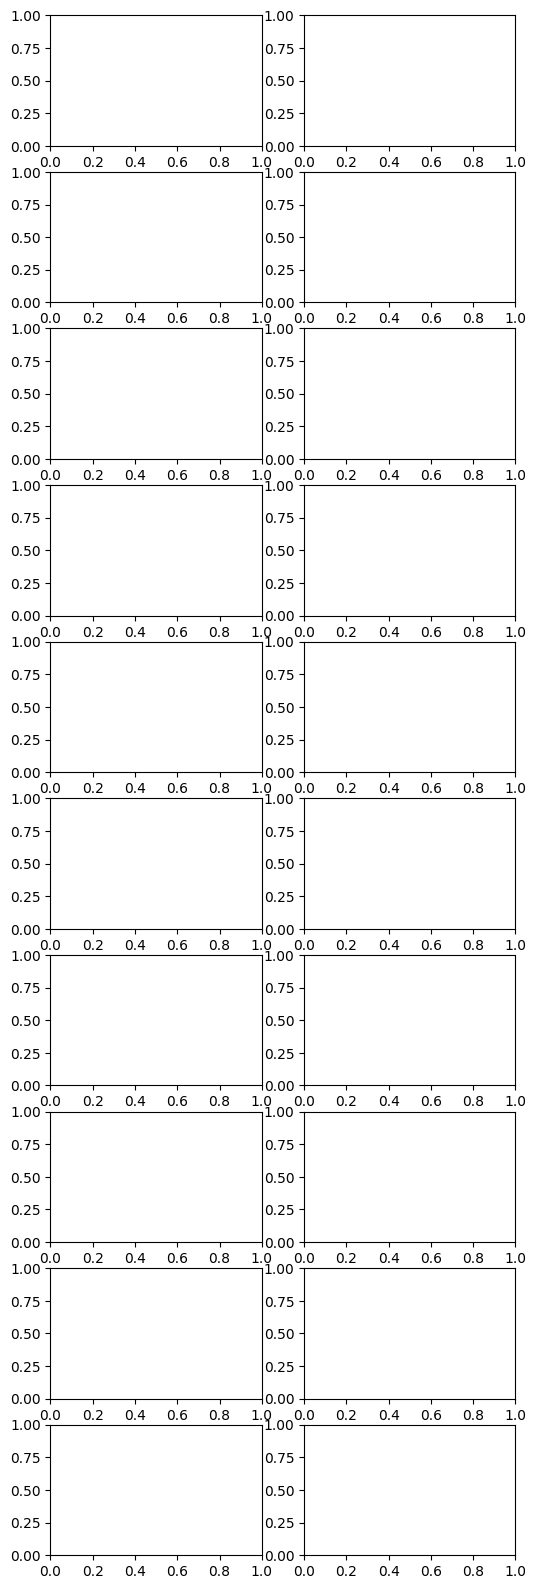

In [ ]:
drive.mount('/content/drive', force_remount=True)
# 1) Réglages et chemins
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR      = '/content/drive/MyDrive/colab'
VAE_WEIGHTS   = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi.pt')
SCALER_PATH   = os.path.join(BASE_DIR, 'vae_analysis', 'scaler.joblib')
ENCODERS_PATH = os.path.join(BASE_DIR, 'vae_analysis', 'encoders.joblib')
DATA_IMG_DIR  = os.path.join(BASE_DIR, 'DATATDI')
vae.load_state_dict(torch.load(VAE_WEIGHTS))
vae.eval()
fig, axs = plt.subplots(10,2,figsize=(6,20))
with torch.no_grad():
    for i in range(10):
        if i>=10: break
        rec,_,_   = vae(x.to(DEVICE))
        orig = (x*0.5+0.5).cpu().squeeze()
        rec  = (rec*0.5+0.5).cpu().squeeze()
        axs[i,0].imshow(orig, cmap='gray'); axs[i,0].axis('off')
        axs[i,1].imshow(rec,  cmap='gray'); axs[i,1].axis('off')
plt.show()

Mounted at /content/drive


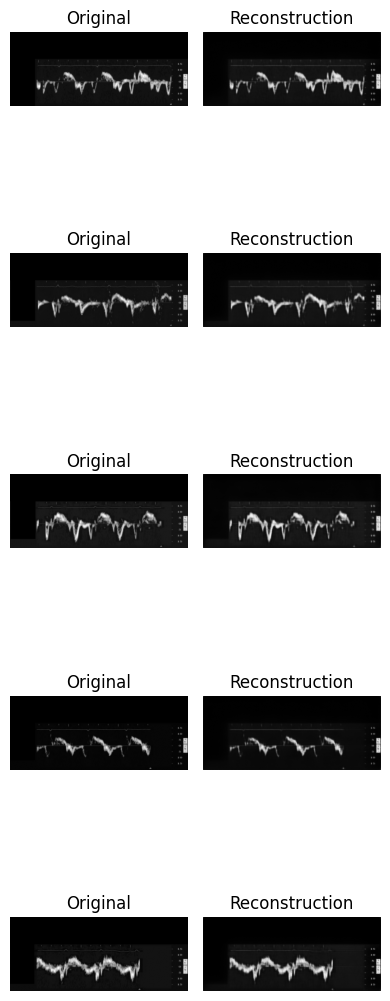

In [ ]:
import os
import torch
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# 1) Réglages et chemins
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR      = '/content/drive/MyDrive/colab'
VAE_WEIGHTS   = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi.pt')
SCALER_PATH   = os.path.join(BASE_DIR, 'vae_analysis', 'scaler.joblib')
ENCODERS_PATH = os.path.join(BASE_DIR, 'vae_analysis', 'encoders.joblib')
DATA_IMG_DIR  = os.path.join(BASE_DIR, 'DATATDI')
CLINICAL_CSV  = os.path.join(BASE_DIR, 'BC_cardiotox_clinical.csv')

# 2) Transforms (1 channel)
img_tf = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize((160, 384)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])

# 3) Dataset pour validation (seulement images TDI)
class TDIDataset(Dataset):
    def __init__(self, img_dir, tf):
        self.paths = []
        for sub in ['CTRCD','NO_CTRCD']:
            folder = os.path.join(img_dir, sub)
            for f in os.listdir(folder):
                if f.lower().endswith('.png'):
                    self.paths.append(os.path.join(folder, f))
        self.tf = tf

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        x   = self.tf(img)
        return x, self.paths[idx]

full_ds = TDIDataset(DATA_IMG_DIR, img_tf)
n_val   = int(len(full_ds) * 0.1)
_, val_ds = random_split(full_ds, [len(full_ds)-n_val, n_val],
                         generator=torch.Generator().manual_seed(42))
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

# 4) Définition du même VAE (1-canal) que vous avez entraîné
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        # définitions d'activations
        self.act     = nn.ReLU()
        self.out_act = nn.Tanh()

        # Encodeur
        self.enc1 = nn.Conv2d(1,   32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32,  64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.enc4 = nn.Conv2d(128,256, 4, 2, 1)

        # Bottleneck (on calcule conv_shape comme avant)
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h     = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim       = int(np.prod(self.conv_shape))

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, flat_dim)

        # Décodeur transposé
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = nn.ConvTranspose2d(128,64, 4,2,1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 4,2,1)
        self.dec1 = nn.ConvTranspose2d(32,  1, 4,2,1)

    def _encode_layers(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e4

    def reparam(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        # encode
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))

        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        z = self.reparam(mu, logvar)

        # decode
        d0 = self.fc_dec(z).view(-1, *self.conv_shape)  # shape [B,256,H/16,W/16]
        d1 = self.act(self.dec4(d0))                    # -> [128,...]
        d1 = d1 + e3                                    # skip
        d2 = self.act(self.dec3(d1))                    # -> [64,...]
        d2 = d2 + e2
        d3 = self.act(self.dec2(d2))                    # -> [32,...]
        d3 = d3 + e1
        recon = self.out_act(self.dec1(d3))             # -> [1,H,W]

        return recon, mu, logvar


# 5) Charger le VAE entraîné
vae = ConvVAE(latent_dim=128,img_size=(160, 384)).to(DEVICE)
vae.load_state_dict(torch.load(VAE_WEIGHTS, map_location=DEVICE))
vae.eval()

# 6) Collecte des 5 premiers samples
orig_samples, rec_samples = [], []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(DEVICE)
        recon, _, _ = vae(xb)
        # dé-normaliser en [0,1]
        orig_np = (xb * 0.5 + 0.5).cpu().numpy()[:,0]
        rec_np  = (recon * 0.5 + 0.5).cpu().numpy()[:,0]
        for o, r in zip(orig_np, rec_np):
            orig_samples.append(o)
            rec_samples.append(r)
            if len(orig_samples) >= 5:
                break
        if len(orig_samples) >= 5:
            break

# 7) Plot
fig, axs = plt.subplots(5, 2, figsize=(4, 12))
for i in range(5):
    axs[i,0].imshow(orig_samples[i], cmap='gray')
    axs[i,0].set_title("Original");   axs[i,0].axis('off')
    axs[i,1].imshow(rec_samples [i], cmap='gray')
    axs[i,1].set_title("Reconstruction"); axs[i,1].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(BASE_DIR, 'vae_reconstructions.png'))
plt.show()


In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM

# Devicet
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Dataset class
class TDIDataset(Dataset):
    def __init__(self, root, size):
        self.files = []
        for sub in ['CTRCD', 'NO_CTRCD']:
            d = os.path.join(root, sub)
            for f in os.listdir(d):
                if f.lower().endswith('.png'):
                    self.files.append(os.path.join(d, f))
        self.tf = T.Compose([
            T.Grayscale(1),
            T.Resize(size),
            T.ToTensor(),
            T.Normalize([0.5], [0.5]),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.tf(img), self.files[i]

# 2) Skip-connection VAE
class SkipConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act = nn.ReLU()
        self.out_act = nn.Tanh()

        # Encoder
        self.enc1 = nn.Conv2d(1, 32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.enc4 = nn.Conv2d(128, 256, 4, 2, 1)

        with torch.no_grad():
            dummy = torch.zeros(1, 1, *img_size)
            h = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim = int(np.prod(self.conv_shape))

        self.fc_mu = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        # Decoder
        self.dec4 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.dec3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.dec1 = nn.ConvTranspose2d(32, 1, 4, 2, 1)

    def _encode_layers(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e4

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))

        flat = e4.flatten(1)
        mu = self.fc_mu(flat)
        logvar = self.fc_logvar(flat)
        z = self.reparam(mu, logvar)

        # Decode
        d0 = self.fc_dec(z).view(-1, *self.conv_shape)
        d1 = self.act(self.dec4(d0)) + e3
        d2 = self.act(self.dec3(d1)) + e2
        d3 = self.act(self.dec2(d2)) + e1
        recon = self.out_act(self.dec1(d3))
        return recon, mu, logvar

# 3) Parameters
BASE_DIR = '/content/drive/MyDrive/colab'
DATA_DIR = os.path.join(BASE_DIR, 'DATATDI')
MODEL_PATH = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi_perc.pt')
IMAGE_SIZE = (160, 384)
BATCH_SIZE = 16
LATENT_DIM = 128

# 4) Strict split
ds = TDIDataset(DATA_DIR, IMAGE_SIZE)
n_val = int(0.2 * len(ds))
n_train = len(ds) - n_val
strict_tr_ds, strict_val_ds = random_split(
    ds, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)
strict_val_loader = DataLoader(strict_val_ds, batch_size=BATCH_SIZE, shuffle=False)

# 5) Load model
vae = SkipConvVAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(MODEL_PATH))
vae.eval()

# 6) Compute metrics
mse_fn = nn.MSELoss()
ssim_fn = SSIM(data_range=2.0, channel=1, win_size=7)
total_mse = 0.0
total_ssim = 0.0
cnt = 0

with torch.no_grad():
    for x, _ in strict_val_loader:
        x = x.to(DEVICE)
        recon, _, _ = vae(x)
        total_mse += mse_fn(recon, x).item() * x.size(0)
        total_ssim += ssim_fn(recon, x).item() * x.size(0)
        cnt += x.size(0)

avg_mse = total_mse / cnt
avg_ssim = total_ssim / cnt
print(f"Generalization (strict val): MSE = {avg_mse:.4f}, SSIM = {avg_ssim:.4f}")

# 7) Visualize reconstructions
fig, axs = plt.subplots(10, 2, figsize=(6, 20))
with torch.no_grad():
    for i in range(10):
        if i >= 10:
            break
        x = x.to(DEVICE)
        recon, _, _ = vae(x)
        orig = (x[0] * 0.5 + 0.5).cpu().squeeze().numpy()
        rec = (recon[0] * 0.5 + 0.5).cpu().squeeze().numpy()
        axs[i, 0].imshow(orig); axs[i, 0].axis('off')
        axs[i,0].set_title("Original");
        axs[i, 1].imshow(rec); axs[i, 1].axis('off')
        axs[i,1].set_title("Reconstruction");

plt.tight_layout()
plt.show()


RuntimeError: Error(s) in loading state_dict for SkipConvVAE:
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([256, 61440]) from checkpoint, the shape in current model is torch.Size([128, 61440]).
	size mismatch for fc_mu.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc_logvar.weight: copying a param with shape torch.Size([256, 61440]) from checkpoint, the shape in current model is torch.Size([128, 61440]).
	size mismatch for fc_logvar.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc_dec.weight: copying a param with shape torch.Size([61440, 256]) from checkpoint, the shape in current model is torch.Size([61440, 128]).

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T
from torchvision.utils import make_grid, save_image
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
# ── 1) Paramètres ──────────────────────────────────────────────────────────────
BASE_DIR    = '/content/drive/MyDrive/colab'
MODEL_PATH  = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi_perc.pt')
OUT_DIR     = os.path.join(BASE_DIR, 'vae_analysis', 'gen_samples')
os.makedirs(OUT_DIR, exist_ok=True)

IMAGE_SIZE  = (160, 384)
BATCH_SIZE  = 16
LATENT_DIM  = 128
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── 2) Dataset ─────────────────────────────────────────────────────────────────
class TDIDataset(Dataset):
    def __init__(self, root, size):
        self.files = []
        for sub in ['CTRCD','NO_CTRCD']:
            d = os.path.join(root, sub)
            for f in os.listdir(d):
                if f.lower().endswith('.png'):
                    self.files.append(os.path.join(d,f))
        self.tf = T.Compose([
            T.Grayscale(1), T.Resize(size),
            T.ToTensor(),    T.Normalize([0.5],[0.5]),
        ])
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.tf(img), self.files[i]

ds = TDIDataset(os.path.join(BASE_DIR,'DATATDI'), IMAGE_SIZE)
n_val = int(0.2*len(ds))
n_tr, n_va = len(ds)-n_val, n_val
_, strict_val_ds = random_split(
    ds, [n_tr, n_va],
    generator=torch.Generator().manual_seed(42)
)
strict_val_loader = DataLoader(strict_val_ds, batch_size=BATCH_SIZE, shuffle=False)

# ── 3) Modèle et utilitaires ───────────────────────────────────────────────────
class SkipConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act, self.out_act = nn.ReLU(), nn.Tanh()
        # encodeur
        self.enc1 = nn.Conv2d(1,32,4,2,1)
        self.enc2 = nn.Conv2d(32,64,4,2,1)
        self.enc3 = nn.Conv2d(64,128,4,2,1)
        self.enc4 = nn.Conv2d(128,256,4,2,1)
        # calcul shape
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim = int(np.prod(self.conv_shape))
        # bottleneck
        self.fc_mu, self.fc_logvar = nn.Linear(flat_dim,latent_dim), nn.Linear(flat_dim,latent_dim)
        self.fc_dec = nn.Linear(latent_dim, flat_dim)
        # décodeur
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = nn.ConvTranspose2d(128,64,4,2,1)
        self.dec2 = nn.ConvTranspose2d(64,32,4,2,1)
        self.dec1 = nn.ConvTranspose2d(32,1,4,2,1)

    def _encode_layers(self, x):
        e1,e2,e3 = self.act(self.enc1(x)), self.act(self.enc2(self.act(self.enc1(x)))), None
        # on se contente de h = enc4(enc3(...)) pour la shape
        return self.act(self.enc4(self.act(self.enc3(e2))))

    def encode(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        return mu, logvar, (e1,e2,e3)

    def reparam(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def skip_decode(self, z, skips):
        # décodeur avec skip (utilisé en reconstruction)
        e1,e2,e3 = skips
        h0 = self.fc_dec(z).view(-1,*self.conv_shape)
        d1 = self.act(self.dec4(h0)) + e3
        d2 = self.act(self.dec3(d1)) + e2
        d3 = self.act(self.dec2(d2)) + e1
        return self.out_act(self.dec1(d3))

    def pure_decode(self, z):
        # décodeur pur (sans skip) pour la génération prior
        h0 = self.fc_dec(z).view(-1,*self.conv_shape)
        x = self.act(self.dec4(h0))
        x = self.act(self.dec3(x))
        x = self.act(self.dec2(x))
        return self.out_act(self.dec1(x))

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparam(mu, logvar)
        recon = self.skip_decode(z, skips)
        return recon, mu, logvar

# instanciation
vae = SkipConvVAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
vae.eval()

# ── 4) 1) Reconstructions (vérif.) ─────────────────────────────────────────────
orig_batch,_ = next(iter(strict_val_loader))
orig_batch = orig_batch.to(DEVICE)
with torch.no_grad():
    recon,_,_ = vae(orig_batch)
imgs = torch.cat([orig_batch[:8], recon[:8]], dim=0)
grid = make_grid((imgs*0.5+0.5).clamp(0,1), nrow=8)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0), cmap='gray'); plt.axis('off')
plt.title("Top : originaux – Bot : reconstructions"); plt.show()
save_image(grid, os.path.join(OUT_DIR,"reconstructions.png"))

# ── 5) 2) Génération pur prior ─────────────────────────────────────────────────
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM, device=DEVICE)
    samples = vae.pure_decode(z)
    samples = (samples*0.5+0.5).clamp(0,1)
grid = make_grid(samples, nrow=8)
plt.figure(figsize=(12,3))
plt.imshow(grid.permute(1,2,0), cmap='gray'); plt.axis('off')
plt.title("Échantillons pure prior (VAE)"); plt.show()
save_image(grid, os.path.join(OUT_DIR,"pure_prior.png"))

# ── 6) 3) Variations autour de vrais latents ────────────────────────────────────
orig2, _ = next(iter(strict_val_loader))
orig2 = orig2.to(DEVICE)[:8]
with torch.no_grad():
    mu, logvar, skips = vae.encode(orig2)
    # 𝑧′ = mu + ε · std où ε ~ U[-1,1]
    std = (0.5*logvar).exp()
    eps = torch.rand_like(std)*2-1
    zp = mu + eps*std
    samples2 = vae.skip_decode(zp, skips)
    samples2 = (samples2*0.5+0.5).clamp(0,1)
grid = make_grid(torch.cat([orig2, samples2],0), nrow=8)
plt.figure(figsize=(12,4))
plt.imshow(grid.permute(1,2,0), cmap='gray'); plt.axis('off')
plt.title("Vrais vs Variations autour du latent"); plt.show()
save_image(grid, os.path.join(OUT_DIR,"posterior_variations.png"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


RuntimeError: Error(s) in loading state_dict for SkipConvVAE:
	size mismatch for fc_mu.weight: copying a param with shape torch.Size([256, 61440]) from checkpoint, the shape in current model is torch.Size([128, 61440]).
	size mismatch for fc_mu.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc_logvar.weight: copying a param with shape torch.Size([256, 61440]) from checkpoint, the shape in current model is torch.Size([128, 61440]).
	size mismatch for fc_logvar.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc_dec.weight: copying a param with shape torch.Size([61440, 256]) from checkpoint, the shape in current model is torch.Size([61440, 128]).

# **add  perceptual loss**

Mounted at /content/drive


Train 1/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 01  Train: 2.2452  Val MSE: 0.8821  SSIM: -0.0008


Train 2/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 02  Train: 2.0049  Val MSE: 0.6442  SSIM: 0.0026


Train 3/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 03  Train: 1.6233  Val MSE: 0.2881  SSIM: 0.0204


Train 4/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 04  Train: 1.2441  Val MSE: 0.1068  SSIM: 0.1304


Train 5/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 05  Train: 0.8157  Val MSE: 0.1111  SSIM: 0.6498


Train 6/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 06  Train: 0.5202  Val MSE: 0.1192  SSIM: 0.6873


Train 7/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 07  Train: 0.5086  Val MSE: 0.1201  SSIM: 0.6910


Train 8/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 08  Train: 0.5022  Val MSE: 0.1175  SSIM: 0.6946


Train 9/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 09  Train: 0.4921  Val MSE: 0.1125  SSIM: 0.6978


Train 10/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10  Train: 0.4792  Val MSE: 0.1034  SSIM: 0.6986


Train 11/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11  Train: 0.4661  Val MSE: 0.0924  SSIM: 0.6972


Train 12/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12  Train: 0.4527  Val MSE: 0.0816  SSIM: 0.7009


Train 13/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13  Train: 0.4393  Val MSE: 0.0722  SSIM: 0.7040


Train 14/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14  Train: 0.4268  Val MSE: 0.0649  SSIM: 0.7074


Train 15/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15  Train: 0.4151  Val MSE: 0.0595  SSIM: 0.7122


Train 16/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16  Train: 0.4026  Val MSE: 0.0538  SSIM: 0.7184


Train 17/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17  Train: 0.3899  Val MSE: 0.0488  SSIM: 0.7239


Train 18/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18  Train: 0.3765  Val MSE: 0.0454  SSIM: 0.7318


Train 19/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19  Train: 0.3632  Val MSE: 0.0407  SSIM: 0.7362


Train 20/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20  Train: 0.3500  Val MSE: 0.0380  SSIM: 0.7433


Train 21/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 21  Train: 0.3358  Val MSE: 0.0337  SSIM: 0.7527


Train 22/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 22  Train: 0.3204  Val MSE: 0.0312  SSIM: 0.7623


Train 23/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 23  Train: 0.3045  Val MSE: 0.0258  SSIM: 0.7761


Train 24/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 24  Train: 0.2871  Val MSE: 0.0233  SSIM: 0.7872


Train 25/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 25  Train: 0.2708  Val MSE: 0.0196  SSIM: 0.7982


Train 26/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 26  Train: 0.2553  Val MSE: 0.0178  SSIM: 0.8083


Train 27/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 27  Train: 0.2408  Val MSE: 0.0162  SSIM: 0.8185


Train 28/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 28  Train: 0.2281  Val MSE: 0.0158  SSIM: 0.8255


Train 29/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 29  Train: 0.2158  Val MSE: 0.0147  SSIM: 0.8357


Train 30/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 30  Train: 0.2046  Val MSE: 0.0139  SSIM: 0.8430


Train 31/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 31  Train: 0.1950  Val MSE: 0.0134  SSIM: 0.8498


Train 32/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 32  Train: 0.1869  Val MSE: 0.0127  SSIM: 0.8536


Train 33/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 33  Train: 0.1792  Val MSE: 0.0121  SSIM: 0.8599


Train 34/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 34  Train: 0.1723  Val MSE: 0.0115  SSIM: 0.8648


Train 35/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 35  Train: 0.1661  Val MSE: 0.0109  SSIM: 0.8689


Train 36/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 36  Train: 0.1604  Val MSE: 0.0105  SSIM: 0.8718


Train 37/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 37  Train: 0.1555  Val MSE: 0.0099  SSIM: 0.8750


Train 38/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 38  Train: 0.1509  Val MSE: 0.0102  SSIM: 0.8795


Train 39/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 39  Train: 0.1463  Val MSE: 0.0097  SSIM: 0.8835


Train 40/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 40  Train: 0.1420  Val MSE: 0.0094  SSIM: 0.8855


Train 41/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 41  Train: 0.1385  Val MSE: 0.0090  SSIM: 0.8886


Train 42/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 42  Train: 0.1343  Val MSE: 0.0087  SSIM: 0.8904


Train 43/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 43  Train: 0.1313  Val MSE: 0.0087  SSIM: 0.8938


Train 44/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 44  Train: 0.1284  Val MSE: 0.0085  SSIM: 0.8965


Train 45/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 45  Train: 0.1249  Val MSE: 0.0078  SSIM: 0.8992


Train 46/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 46  Train: 0.1218  Val MSE: 0.0078  SSIM: 0.8990


Train 47/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 47  Train: 0.1190  Val MSE: 0.0076  SSIM: 0.9025


Train 48/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 48  Train: 0.1154  Val MSE: 0.0073  SSIM: 0.9047


Train 49/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 49  Train: 0.1127  Val MSE: 0.0073  SSIM: 0.9064


Train 50/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 50  Train: 0.1099  Val MSE: 0.0072  SSIM: 0.9092


Train 51/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 51  Train: 0.1072  Val MSE: 0.0069  SSIM: 0.9112


Train 52/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 52  Train: 0.1047  Val MSE: 0.0068  SSIM: 0.9126


Train 53/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 53  Train: 0.1024  Val MSE: 0.0068  SSIM: 0.9148


Train 54/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 54  Train: 0.1001  Val MSE: 0.0068  SSIM: 0.9157


Train 55/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 55  Train: 0.0983  Val MSE: 0.0066  SSIM: 0.9177


Train 56/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 56  Train: 0.0966  Val MSE: 0.0063  SSIM: 0.9190


Train 57/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 57  Train: 0.0944  Val MSE: 0.0063  SSIM: 0.9202


Train 58/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 58  Train: 0.0928  Val MSE: 0.0060  SSIM: 0.9221


Train 59/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 59  Train: 0.0911  Val MSE: 0.0058  SSIM: 0.9228


Train 60/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 60  Train: 0.0893  Val MSE: 0.0059  SSIM: 0.9235


Train 61/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 61  Train: 0.0878  Val MSE: 0.0057  SSIM: 0.9257


Train 62/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 62  Train: 0.0863  Val MSE: 0.0055  SSIM: 0.9270


Train 63/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 63  Train: 0.0849  Val MSE: 0.0055  SSIM: 0.9284


Train 64/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 64  Train: 0.0836  Val MSE: 0.0055  SSIM: 0.9291


Train 65/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 65  Train: 0.0825  Val MSE: 0.0051  SSIM: 0.9307


Train 66/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 66  Train: 0.0808  Val MSE: 0.0052  SSIM: 0.9317


Train 67/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 67  Train: 0.0797  Val MSE: 0.0053  SSIM: 0.9296


Train 68/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 68  Train: 0.0778  Val MSE: 0.0050  SSIM: 0.9341


Train 69/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 69  Train: 0.0770  Val MSE: 0.0049  SSIM: 0.9344


Train 70/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 70  Train: 0.0757  Val MSE: 0.0047  SSIM: 0.9350


Train 71/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 71  Train: 0.0748  Val MSE: 0.0046  SSIM: 0.9360


Train 72/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 72  Train: 0.0735  Val MSE: 0.0044  SSIM: 0.9376


Train 73/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 73  Train: 0.0725  Val MSE: 0.0042  SSIM: 0.9394


Train 74/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 74  Train: 0.0709  Val MSE: 0.0043  SSIM: 0.9380


Train 75/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 75  Train: 0.0701  Val MSE: 0.0041  SSIM: 0.9394


Train 76/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 76  Train: 0.0688  Val MSE: 0.0040  SSIM: 0.9414


Train 77/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 77  Train: 0.0679  Val MSE: 0.0040  SSIM: 0.9427


Train 78/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 78  Train: 0.0663  Val MSE: 0.0038  SSIM: 0.9429


Train 79/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 79  Train: 0.0659  Val MSE: 0.0038  SSIM: 0.9445


Train 80/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 80  Train: 0.0646  Val MSE: 0.0038  SSIM: 0.9449


Train 81/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 81  Train: 0.0635  Val MSE: 0.0036  SSIM: 0.9462


Train 82/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 82  Train: 0.0627  Val MSE: 0.0035  SSIM: 0.9475


Train 83/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 83  Train: 0.0622  Val MSE: 0.0035  SSIM: 0.9484


Train 84/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 84  Train: 0.0608  Val MSE: 0.0034  SSIM: 0.9482


Train 85/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 85  Train: 0.0596  Val MSE: 0.0034  SSIM: 0.9491


Train 86/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 86  Train: 0.0589  Val MSE: 0.0033  SSIM: 0.9502


Train 87/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 87  Train: 0.0584  Val MSE: 0.0033  SSIM: 0.9503


Train 88/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 88  Train: 0.0574  Val MSE: 0.0032  SSIM: 0.9515


Train 89/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 89  Train: 0.0570  Val MSE: 0.0032  SSIM: 0.9521


Train 90/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 90  Train: 0.0560  Val MSE: 0.0032  SSIM: 0.9527


Train 91/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 91  Train: 0.0552  Val MSE: 0.0030  SSIM: 0.9532


Train 92/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 92  Train: 0.0548  Val MSE: 0.0031  SSIM: 0.9539


Train 93/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 93  Train: 0.0537  Val MSE: 0.0031  SSIM: 0.9544


Train 94/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 94  Train: 0.0531  Val MSE: 0.0030  SSIM: 0.9553


Train 95/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 95  Train: 0.0527  Val MSE: 0.0030  SSIM: 0.9558


Train 96/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 96  Train: 0.0521  Val MSE: 0.0029  SSIM: 0.9562


Train 97/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 97  Train: 0.0514  Val MSE: 0.0028  SSIM: 0.9571


Train 98/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 98  Train: 0.0506  Val MSE: 0.0028  SSIM: 0.9576


Train 99/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 99  Train: 0.0506  Val MSE: 0.0029  SSIM: 0.9578


Train 100/100:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 100  Train: 0.0500  Val MSE: 0.0029  SSIM: 0.9585


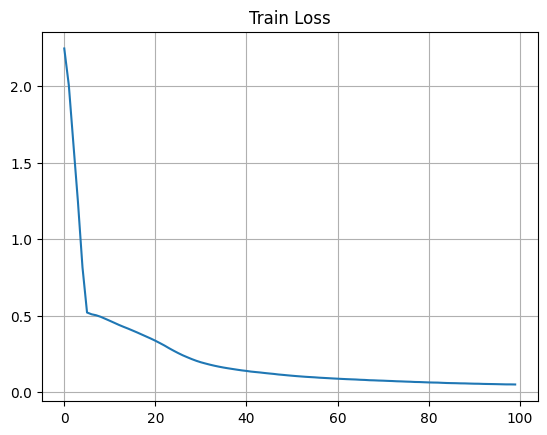

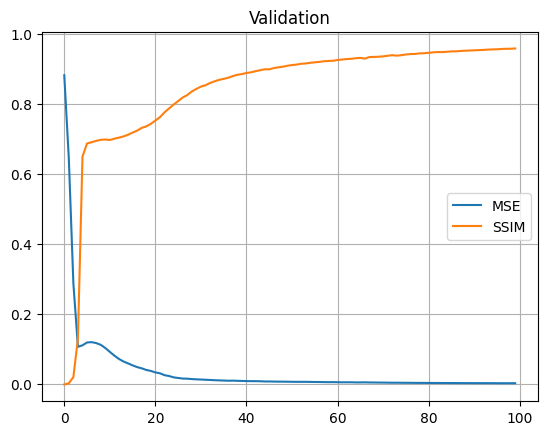

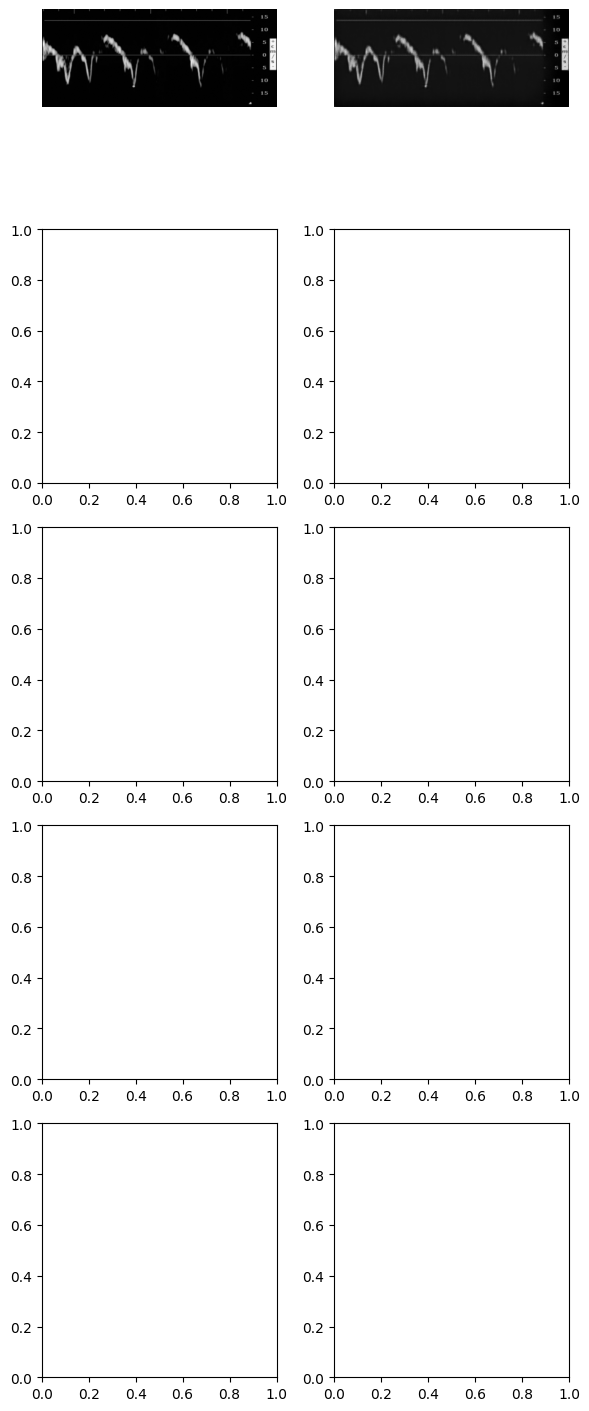

In [ ]:
import os
import random
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T, models
import matplotlib.pyplot as plt
from pytorch_msssim import SSIM

# ── 0) Réglages ───────────────────────────────────────────────────────────────
seed      = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Montez votre Drive si nécessaire
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR  = '/content/drive/MyDrive/colab'
DATA_DIR  = os.path.join(BASE_DIR, 'DATATDI')
OUT_DIR   = os.path.join(BASE_DIR, 'vae_analysis')
os.makedirs(OUT_DIR, exist_ok=True)

IMAGE_SIZE  = (160, 384)
BATCH_SIZE  = 32
LR          = 1e-4
EPOCHS      = 100
LATENT_DIM  = 256
BETA_KL     = 0.1    # pondération KL
ALPHA_SSIM  = 1.0    # poids du SSIM
LAMBDA_PERC = 0.01   # poids du perceptual loss

# ── 1) Dataset TDI 1-canal ─────────────────────────────────────────────────────
class TDIDataset(Dataset):
    def __init__(self, root, size):
        self.files = []
        for sub in ['CTRCD','NO_CTRCD']:
            d = os.path.join(root, sub)
            for f in os.listdir(d):
                if f.lower().endswith('.png'):
                    self.files.append(os.path.join(d,f))
        self.tf = T.Compose([
            T.Grayscale(1),
            T.Resize(size),
            T.ToTensor(),
            T.Normalize([0.5],[0.5]),
        ])
    def __len__(self):
        return len(self.files)
    def __getitem__(self, i):
        img = Image.open(self.files[i]).convert('RGB')
        return self.tf(img), self.files[i]

ds = TDIDataset(DATA_DIR, IMAGE_SIZE)
n_val = int(0.1 * len(ds))
n_train = len(ds) - n_val
tr_ds, va_ds = random_split(ds, [n_train, n_val],
                            generator=torch.Generator().manual_seed(seed))
tr_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
va_loader = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# ── 2) ConvVAE avec skip-connections ───────────────────────────────────────────
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act     = nn.ReLU()
        self.out_act = nn.Tanh()

        # Encodeur
        self.enc1 = nn.Conv2d(1,   32, 4, 2, 1)
        self.enc2 = nn.Conv2d(32,  64, 4, 2, 1)
        self.enc3 = nn.Conv2d(64, 128, 4, 2, 1)
        self.enc4 = nn.Conv2d(128,256, 4, 2, 1)

        # Calcul dynamique du shape
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h     = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim       = int(np.prod(self.conv_shape))

        # Bottleneck
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, flat_dim)

        # Décodeur transposé
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = nn.ConvTranspose2d(128,64, 4,2,1)
        self.dec2 = nn.ConvTranspose2d(64, 32, 4,2,1)
        self.dec1 = nn.ConvTranspose2d(32,  1, 4,2,1)

    def _encode_layers(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e4

    def reparam(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encode
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))

        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        z = self.reparam(mu, logvar)

        # Decode with skip
        d0 = self.fc_dec(z).view(-1, *self.conv_shape)
        d1 = self.act(self.dec4(d0)) + e3
        d2 = self.act(self.dec3(d1)) + e2
        d3 = self.act(self.dec2(d2)) + e1
        recon = self.out_act(self.dec1(d3))

        return recon, mu, logvar

# ── 3) Critères et VGG pour perceptual loss ───────────────────────────────────
mse_fn  = nn.MSELoss()
ssim_fn = SSIM(data_range=2.0, channel=1, win_size=7)

# VGG perceptual
vgg = models.vgg16(pretrained=True).features[:16].to(DEVICE).eval()
for p in vgg.parameters():
    p.requires_grad = False
def perceptual_loss(x, recon):
    # dupliquer canaux
    fx   = vgg(x.repeat(1,3,1,1))
    frec = vgg(recon.repeat(1,3,1,1))
    return F.mse_loss(frec, fx)

# ── 4) Initialisation ─────────────────────────────────────────────────────────
vae = ConvVAE(LATENT_DIM, IMAGE_SIZE).to(DEVICE)
opt = torch.optim.AdamW(vae.parameters(), lr=LR)

train_losses, val_mses, val_ssims = [], [], []

# ── 5) Entraînement ────────────────────────────────────────────────────────────
for ep in range(1, EPOCHS+1):
    vae.train()
    run_loss = 0.0
    for x,_ in tqdm(tr_loader, desc=f"Train {ep}/{EPOCHS}"):
        x = x.to(DEVICE)
        opt.zero_grad()

        recon, mu, logvar = vae(x)
        l_mse   = mse_fn(recon, x)
        l_ssim  = 1 - ssim_fn(recon, x)
        kld     = -0.5 * (1 + logvar - logvar.exp() - mu.pow(2)).mean()
        l_perc  = perceptual_loss(x, recon)

        loss = l_mse + ALPHA_SSIM * l_ssim + BETA_KL * kld + LAMBDA_PERC * l_perc
        loss.backward()
        opt.step()
        run_loss += loss.item() * x.size(0)

    train_losses.append(run_loss / len(tr_ds))

    # Validation
    vae.eval()
    vs_mse, vs_ssim, cnt = 0.0, 0.0, 0
    with torch.no_grad():
        for x,_ in va_loader:
            x = x.to(DEVICE)
            recon,_,_ = vae(x)
            vs_mse  += mse_fn(recon, x).item() * x.size(0)
            vs_ssim += ssim_fn(recon, x).item() * x.size(0)
            cnt    += x.size(0)
    val_mses.append(vs_mse/cnt)
    val_ssims.append(vs_ssim/cnt)

    print(f"Epoch {ep:02d}  Train: {train_losses[-1]:.4f}  Val MSE: {val_mses[-1]:.4f}  SSIM: {val_ssims[-1]:.4f}")

# ── 6) Sauvegarde et plots ─────────────────────────────────────────────────────
torch.save(vae.state_dict(), os.path.join(OUT_DIR, 'vae_tdi_perc.pt'))
plt.figure(); plt.plot(train_losses); plt.title("Train Loss"); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "train_loss.png"))
plt.figure()
plt.plot(val_mses, label="MSE"); plt.plot(val_ssims, label="SSIM")
plt.legend(); plt.title("Validation"); plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, "val_metrics.png"))

# ── 7) Inspection qualitative ──────────────────────────────────────────────────
vae.eval()
fig, axs = plt.subplots(5,2,figsize=(6,15))
with torch.no_grad():
    for i,(x,_) in enumerate(va_loader):
        if i >= 5: break
        x = x.to(DEVICE)
        recon,_,_ = vae(x)
        orig = (x*0.5+0.5).clamp(0,1)
        rec  = (recon*0.5+0.5).clamp(0,1)
        axs[i,0].imshow(orig[0,0].cpu(), cmap='gray'); axs[i,0].axis('off')
        axs[i,1].imshow(rec[0,0].cpu(), cmap='gray'); axs[i,1].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "reconstructions_perc.png"))
plt.show()


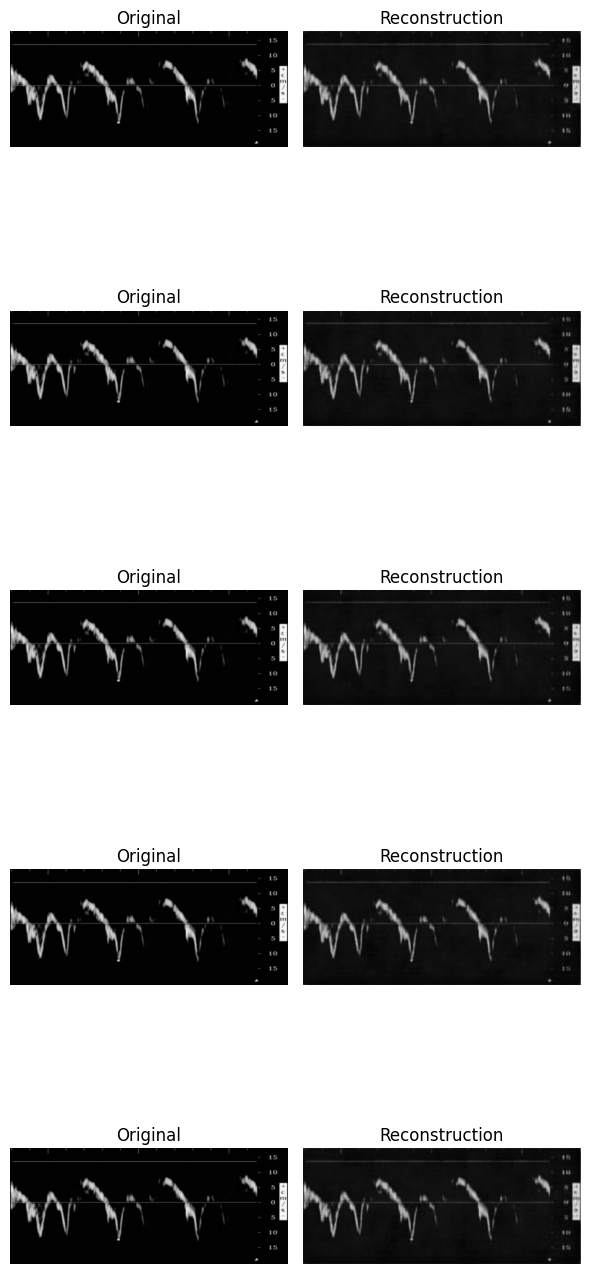

In [ ]:
vae.eval()
fig, axs = plt.subplots(5,2,figsize=(6,15))
with torch.no_grad():
    for i in range(10):
        if i >= 5: break
        x = x.to(DEVICE)
        recon,_,_ = vae(x)
        orig = (x*0.5+0.5).clamp(0,1)
        rec  = (recon*0.5+0.5).clamp(0,1)
        axs[i,0].imshow(orig[0,0].cpu(), cmap='gray'); axs[i,0].axis('off'),axs[i,0].set_title("Original")
        axs[i,1].imshow(rec[0,0].cpu(), cmap='gray'); axs[i,1].axis('off'),axs[i,1].set_title("Reconstruction")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "reconstructions_perc.png"))
plt.show()


## **DIFFUSION**

In [ ]:
import os
import random
import joblib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms as T, models
from diffusers import UNet2DConditionModel, DDPMScheduler, DPMSolverMultistepScheduler
from pytorch_msssim import MS_SSIM   # on conserve MS-SSIM
from sklearn.preprocessing import StandardScaler, LabelEncoder

# ── 0) Réglages globaux ─────────────────────────────────────────────────────────
seed    = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
DEVICE  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = True
early_stop_patience = 40

# ── 1) Montage Drive ────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE_DIR       = '/content/drive/MyDrive/colab'
DATA_IMG_DIR   = os.path.join(BASE_DIR, 'DATATDI')
CLINICAL_CSV   = os.path.join(BASE_DIR, 'BC_cardiotox_clinical.csv')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'vae_analysis')
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# ── 2) Hyper‐paramètres ──────────────────────────────────────────────────────────
IMAGE_SIZE       = (160, 384)
BATCH_SIZE       = 128
LR               = 5e-5
EPOCHS           = 200
TIMESTEPS_COARSE = 100
TIMESTEPS_FINE   = 1000
THRESH_EPOCH     = int(EPOCHS * 0.8)
GUIDANCE_SCALE   = 4.0
NUM_WORKERS      = 0

LAMBDA_PERC_DIFF = 0.1   # poids perceptual loss
LAMBDA_SSIM_DIFF = 1.0   # poids MS-SSIM loss

# ── 3) Transforms ───────────────────────────────────────────────────────────────
augment_tf = T.Compose([
    T.ColorJitter(0.2,0.2,0.2,0.1),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.Resize(IMAGE_SIZE),
])
base_tf = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])

# ── 4) ConvVAE défini et chargé ─────────────────────────────────────────────────
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act, self.out_act = nn.ReLU(), nn.Tanh()
        # Encodeur
        self.enc1 = nn.Conv2d(1,32,4,2,1)
        self.enc2 = nn.Conv2d(32,64,4,2,1)
        self.enc3 = nn.Conv2d(64,128,4,2,1)
        self.enc4 = nn.Conv2d(128,256,4,2,1)
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h     = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
            flat_dim       = int(np.prod(self.conv_shape))
        # Bottleneck
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, flat_dim)
        # Décodeur
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = nn.ConvTranspose2d(128,64,4,2,1)
        self.dec2 = nn.ConvTranspose2d(64,32,4,2,1)
        self.dec1 = nn.ConvTranspose2d(32,1,4,2,1)

    def _encode_layers(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e4

    def forward(self, x):
        e4   = self._encode_layers(x)            # [B,256,H',W']
        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        return mu, logvar, e4

    def decode(self, h):
        d1 = self.act(self.dec4(h))
        d2 = self.act(self.dec3(d1))
        d3 = self.act(self.dec2(d2))
        return self.out_act(self.dec1(d3))

vae = ConvVAE(latent_dim=128, img_size=IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(
    os.path.join(BASE_DIR,'vae_analysis','vae_tdi_perc.pt'),
    map_location=DEVICE
))
vae.eval()

# ── 5) Dataset des latents spatiaux + contexte clinique ────────────────────────
class LatentDataset(Dataset):
    def __init__(self, data_dir, clinical_csv, device):
        df = pd.read_csv(clinical_csv, sep=',')
        df['patient_id'] = df['patient_id'].astype(str)
        # numériques
        num_cols = ['age','weight','height','time','LVEF','heart_rate','PWT','LAd','LVDd','LVSd']
        df[num_cols] = df[num_cols].replace(',', '.', regex=True).astype(float)
        self.scaler = StandardScaler().fit(df[num_cols])
        df[num_cols] = self.scaler.transform(df[num_cols])
        # catégoriques
        cat_cols = ['heart_rhythm','AC','antiHER2','ACprev','antiHER2prev','HTA','DL',
                    'DM','smoker','exsmoker','RTprev','CIprev','ICMprev','ARRprev',
                    'VALVprev','cxvalv']
        self.label_encoders = {}
        for c in cat_cols:
            df[c] = df[c].fillna('0').astype(str)
            le     = LabelEncoder().fit(df[c])
            df[c]  = le.transform(df[c])
            self.label_encoders[c] = le
        # tenseur clinique
        self.clinical = torch.tensor(df[num_cols+cat_cols].values, dtype=torch.float32)

        latents, labels = [], []
        for pid, lbl in zip(df['patient_id'], df['CTRCD']):
            sub = 'CTRCD' if lbl==1 else 'NO_CTRCD'
            img = Image.open(os.path.join(data_dir, sub, f"image ({pid}).png")).convert('RGB')
            img = augment_tf(img)
            x   = base_tf(img).unsqueeze(0).to(device)  # [1,1,H,W]
            with torch.no_grad():
                _,_, h = vae(x)                         # [1,256,10,24]
            latents.append(h.squeeze(0).cpu())
            labels.append(lbl)
        self.lats   = torch.stack(latents)            # [N,256,10,24]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self): return len(self.lats)
    def __getitem__(self, idx): return self.lats[idx], self.clinical[idx], self.labels[idx]

# ── 6) Dataloaders ─────────────────────────────────────────────────────────────
ds     = LatentDataset(DATA_IMG_DIR, CLINICAL_CSV, DEVICE)
n_val  = int(0.1 * len(ds))
n_tr   = len(ds) - n_val
tr_ds, va_ds = random_split(ds, [n_tr, n_val], generator=torch.Generator().manual_seed(seed))
train_loader = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ── 7) UNet2DConditionModel sur latents 256×10×24 ─────────────────────────────
dummy_lat, _, _ = ds[0]
C, Hf, Wf = dummy_lat.shape
model = UNet2DConditionModel(
    sample_size         = (Hf, Wf),
    in_channels         = C,
    out_channels        = C,
    down_block_types    = ("DownBlock2D",)*4,
    up_block_types      = ("UpBlock2D",)*4,
    block_out_channels  = (128,256,512,1024),
    cross_attention_dim = ds.clinical.shape[1],
).to(DEVICE)

# ── 8) Scheduler, optim, pertes ─────────────────────────────────────────────────
noise_scheduler    = DDPMScheduler(num_train_timesteps=TIMESTEPS_COARSE)
sampling_scheduler = DPMSolverMultistepScheduler.from_config(noise_scheduler.config)
sampling_scheduler.set_timesteps(TIMESTEPS_COARSE)

optimizer   = torch.optim.AdamW(model.parameters(), lr=LR)
lr_scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-7
)

mse_fn  = nn.MSELoss()
# <-- main change: on utilise win_size=7 pour MS_SSIM afin de satisfaire la condition de taille
ssim_fn = MS_SSIM(data_range=2.0, channel=1, size_average=True, win_size=7)
scaler  = torch.amp.GradScaler(enabled=USE_AMP)

# ── 9) Perceptual loss (VGG) ────────────────────────────────────────────────────
vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16].to(DEVICE).eval()
for p in vgg.parameters(): p.requires_grad = False
def perceptual_loss(img_pred, img_gt):
    fp = vgg(img_pred.repeat(1,3,1,1))
    fg = vgg(img_gt.repeat(1,3,1,1))
    return F.mse_loss(fp, fg)

def psnr_from_mse(mse): return 10 * torch.log10(1.0 / mse)

# ── 10) Boucle d'entraînement & validation ─────────────────────────────────────
best_val, no_improve = float('inf'), 0
for epoch in range(1, EPOCHS+1):
    if epoch == THRESH_EPOCH:
        noise_scheduler    = DDPMScheduler(num_train_timesteps=TIMESTEPS_FINE)
        sampling_scheduler = DPMSolverMultistepScheduler.from_config(noise_scheduler.config)
        sampling_scheduler.set_timesteps(TIMESTEPS_FINE)

    model.train()
    for lat, conds, _ in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}"):
        lat   = lat.to(DEVICE)
        conds = conds.unsqueeze(1).to(DEVICE)

        noise = torch.randn_like(lat)
        ts    = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                              (lat.size(0),), device=DEVICE)
        noisy = noise_scheduler.add_noise(lat, noise, ts)

        with torch.amp.autocast(device_type="cuda", enabled=USE_AMP):
            uncond   = model(noisy, ts, encoder_hidden_states=torch.zeros_like(conds)).sample
            cond     = model(noisy, ts, encoder_hidden_states=conds).sample
            eps      = uncond + GUIDANCE_SCALE * (cond - uncond)
            loss_mse = mse_fn(eps, noise)

            # prédiction x0 vectorisée
            alphas = torch.tensor(noise_scheduler.alphas_cumprod, device=DEVICE)
            a_t    = alphas[ts].view(-1,1,1,1)
            x0_pred = (noisy - torch.sqrt(1 - a_t)*eps) / torch.sqrt(a_t)

            recon_pred = vae.decode(x0_pred)
            recon_gt   = vae.decode(lat)

            loss_perc = perceptual_loss(recon_pred, recon_gt)
            rp, rg    = recon_pred + 1.0, recon_gt + 1.0
            loss_ssim = 1 - ssim_fn(rp, rg)

            loss = loss_mse \
                   + LAMBDA_PERC_DIFF * loss_perc \
                   + LAMBDA_SSIM_DIFF * loss_ssim

        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer); scaler.update(); optimizer.zero_grad()

    model.eval()
    sum_mse, sum_ssim, sum_psnr, n = 0,0,0,0
    with torch.no_grad():
        for lat, conds, _ in val_loader:
            lat   = lat.to(DEVICE)
            conds = conds.unsqueeze(1).to(DEVICE)

            noise = torch.randn_like(lat)
            ts    = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (lat.size(0),), device=DEVICE)
            noisy = noise_scheduler.add_noise(lat, noise, ts)

            uncond = model(noisy, ts, encoder_hidden_states=torch.zeros_like(conds)).sample
            cond   = model(noisy, ts, encoder_hidden_states=conds).sample
            eps    = uncond + GUIDANCE_SCALE * (cond - uncond)

            prevs = [
                noise_scheduler.step(eps[i:i+1], int(ts[i]), noisy[i:i+1]).prev_sample
                for i in range(lat.size(0))
            ]
            recon_lat = torch.cat(prevs, 0)

            mse_v  = mse_fn(recon_lat, lat).item()
            recon_img = vae.decode(recon_lat)
            gt_img    = vae.decode(lat)
            rp, rg    = recon_img + 1.0, gt_img + 1.0

            ssim_v    = ssim_fn(rp, rg).item()
            psnr_v    = psnr_from_mse(torch.tensor(mse_v)).item()

            sum_mse  += mse_v * lat.size(0)
            sum_ssim += ssim_v * lat.size(0)
            sum_psnr += psnr_v * lat.size(0)
            n        += lat.size(0)

    avg_mse  = sum_mse / n
    avg_ssim = sum_ssim / n
    avg_psnr = sum_psnr / n
    print(f"Val {epoch:03d}: MSE={avg_mse:.4f}, SSIM={avg_ssim:.4f}, PSNR={avg_psnr:.2f}dB")

    lr_scheduler.step(avg_mse)
    if avg_mse < best_val:
        best_val, no_improve = avg_mse, 0
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_DIR,'best_model.pt'))
        joblib.dump(ds.scaler,        os.path.join(MODEL_SAVE_DIR,'scaler.joblib'))
        joblib.dump(ds.label_encoders,os.path.join(MODEL_SAVE_DIR,'encoders.joblib'))
        print("→ Nouveau best enregistré")
    else:
        no_improve += 1
        if no_improve >= early_stop_patience:
            print("→ Early stopping"); break

print("🏁 Entraînement terminé — best_model.pt sauvegardé")


/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or
/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


ValueError: mount failed

# **Reconstruction**

Google Drive unmounted.
Mounted at /content/drive


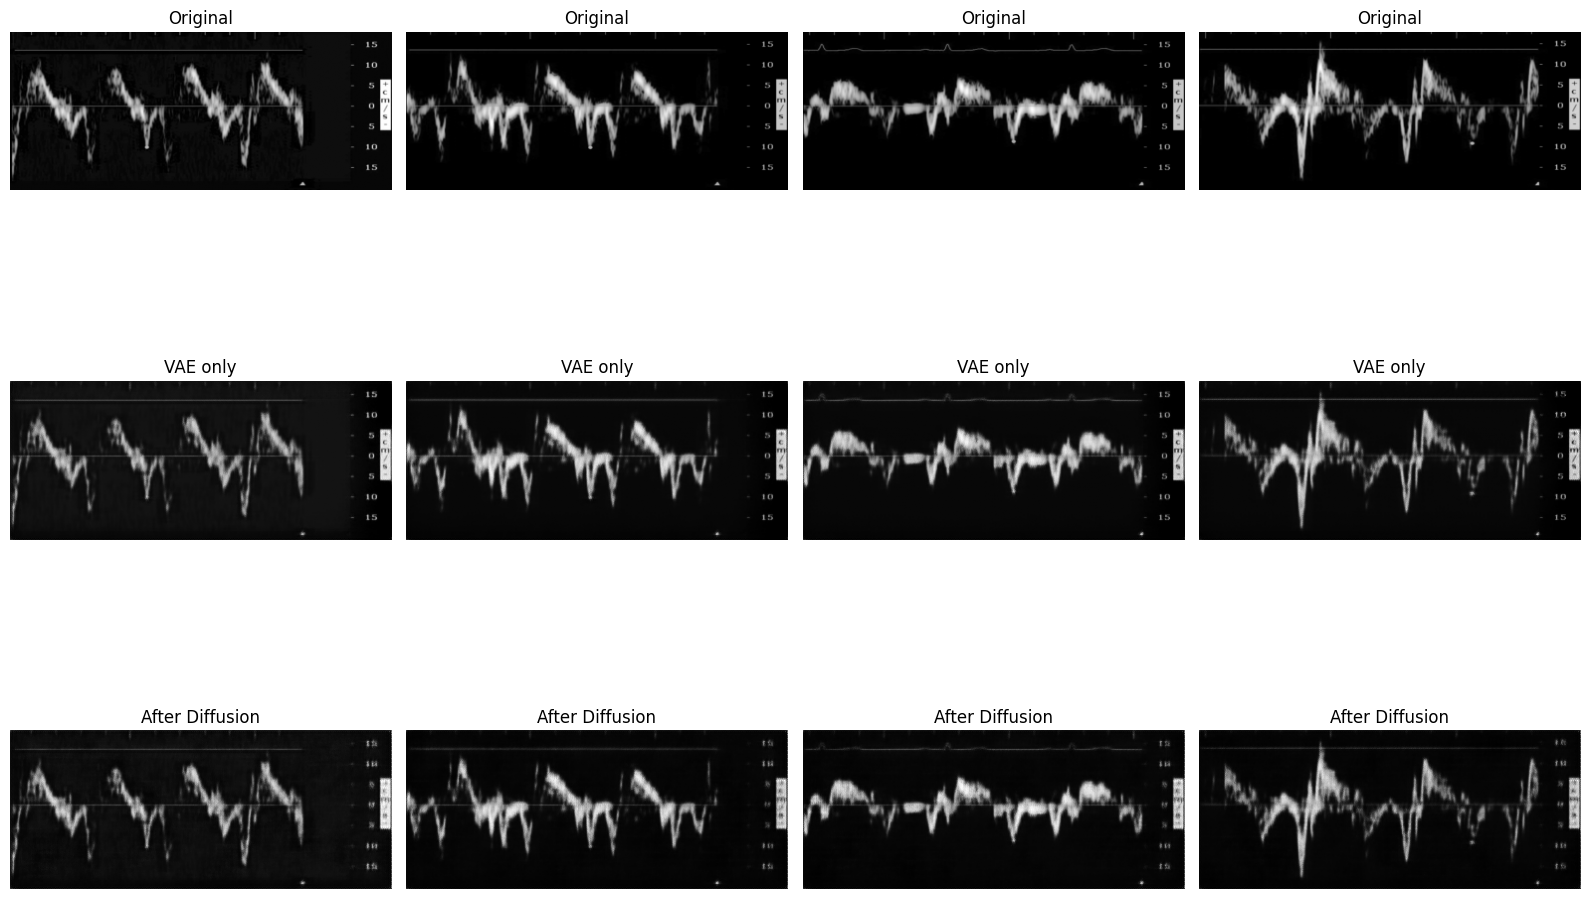

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from diffusers import DDPMScheduler, UNet2DConditionModel

# ── 1) Unmount Drive if it's already mounted and clear the directory ───────────
# Check if drive is already mounted
if os.path.exists('/content/drive/MyDrive'):
    try:
        # Attempt to unmount
        !fusermount -uz /content/drive
        print("Google Drive unmounted.")
    except Exception as e:
        print(f"Error unmounting Google Drive: {e}")

# Ensure the mountpoint directory is empty
mountpoint = '/content/drive'
if os.path.exists(mountpoint) and os.path.isdir(mountpoint):
    if os.listdir(mountpoint):
        print(f"Cleaning mountpoint directory: {mountpoint}")
        # Remove all contents in the directory
        !rm -rf {mountpoint}/*
        # Recreate the directory if it was removed
        if not os.path.exists(mountpoint):
            os.makedirs(mountpoint)


# ── 2) Mount Drive ───────────────────────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)


# ── 1) Réglages ───────────────────────────────────────────────────────────────
DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR       = '/content/drive/MyDrive/colab'
DATA_IMG_DIR   = os.path.join(BASE_DIR, 'DATATDI')
MODEL_SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
IMAGE_SIZE     = (160, 384)
BATCH_SIZE     = 4
TIMESTEPS      = 600   # nombre de pas

# Colonnes cliniques (exemple)
cross_dim = 26

# ── 2) Transform pour images TDI ──────────────────────────────────────────────
tf_image = T.Compose([
    T.Grayscale(1),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.5],[0.5]),
])

# ── 3) Dataset brut pour affichage ────────────────────────────────────────────
class TDIDataset(Dataset):
    def __init__(self, root):
        self.paths = []
        for sub in ('CTRCD','NO_CTRCD'):
            for f in os.listdir(os.path.join(root, sub)):
                if f.lower().endswith('.png'):
                    self.paths.append(os.path.join(root, sub, f))
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        p = self.paths[idx]
        img = Image.open(p).convert('RGB')
        return tf_image(img), p

raw_loader = DataLoader(TDIDataset(DATA_IMG_DIR), batch_size=BATCH_SIZE, shuffle=True)

# ── 4) Votre ConvVAE (skip‐connections) ────────────────────────────────────────
class ConvVAE(nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        Act = nn.ReLU
        # encodeur
        self.enc1 = nn.Conv2d(1,32,4,2,1); self.a1=Act()
        self.enc2 = nn.Conv2d(32,64,4,2,1); self.a2=Act()
        self.enc3 = nn.Conv2d(64,128,4,2,1); self.a3=Act()
        self.enc4 = nn.Conv2d(128,256,4,2,1); self.a4=Act()
        # conv_shape déterminé par architecture
        Hf, Wf = img_size[0]//16, img_size[1]//16
        self.conv_shape = (256, Hf, Wf)
        flat_dim = 256*Hf*Wf
        # bottleneck
        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = nn.Linear(latent_dim, flat_dim)
        # décodeur
        self.dec4 = nn.ConvTranspose2d(256,128,4,2,1); self.b4=Act()
        self.dec3 = nn.ConvTranspose2d(128,64, 4,2,1); self.b3=Act()
        self.dec2 = nn.ConvTranspose2d(64,32,  4,2,1); self.b2=Act()
        self.dec1 = nn.ConvTranspose2d(32,1,   4,2,1)

    def forward(self, x):
        e1 = self.a1(self.enc1(x))
        e2 = self.a2(self.enc2(e1))
        e3 = self.a3(self.enc3(e2))
        e4 = self.a4(self.enc4(e3))
        flat = e4.flatten(1)
        mu, logvar = self.fc_mu(flat), self.fc_logvar(flat)
        return mu, logvar, (e1,e2,e3,e4)

    def reparam(self, mu, logvar):
        std = (0.5*logvar).exp()
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, h, skips):
        e1,e2,e3,_ = skips
        h = self.b4(self.dec4(h)) + e3
        h = self.b3(self.dec3(h)) + e2
        h = self.b2(self.dec2(h)) + e1
        return torch.tanh(self.dec1(h))

    def reconstruct(self, x):
        mu, logvar, skips = self.forward(x)
        z = self.reparam(mu, logvar)
        flat = self.fc_dec(z)
        h = flat.view(-1, *self.conv_shape)
        return self.decode(h, skips)

# charger VAE
vae = ConvVAE(latent_dim=256, img_size=IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(
    os.path.join(BASE_DIR,'vae_analysis','vae_tdi_perc.pt'),
    map_location=DEVICE
))
vae.eval()

# ── 5) UNet conditionnel ───────────────────────────────────────────────────────
Hf, Wf = IMAGE_SIZE[0]//16, IMAGE_SIZE[1]//16
unet = UNet2DConditionModel(
    sample_size         = (Hf, Wf),
    in_channels         = vae.conv_shape[0],
    out_channels        = vae.conv_shape[0],
    down_block_types    = ("DownBlock2D",)*4,
    up_block_types      = ("UpBlock2D",)*4,
    block_out_channels  = (128,256,512,1024),
    cross_attention_dim = cross_dim,
).to(DEVICE)
unet.load_state_dict(torch.load(
    os.path.join(MODEL_SAVE_DIR,'best_model.pt'),
    map_location=DEVICE
))
unet.eval()

# ── 6) Scheduler DDPM ─────────────────────────────────────────────────────────
scheduler = DDPMScheduler(num_train_timesteps=TIMESTEPS)
scheduler.set_timesteps(TIMESTEPS)
alphas = scheduler.alphas_cumprod.to(DEVICE)

# ── 7) Inference + affichage ─────────────────────────────────────────────────
batch,_ = next(iter(raw_loader))
x = batch.to(DEVICE)
with torch.no_grad():
    rec_vae = vae.reconstruct(x).cpu()
    _,_,skips = vae.forward(x)
    sample = skips[-1].clone()

    for t in scheduler.timesteps:
        t_i      = int(t)
        eps_pred = unet(
            sample,
            torch.tensor([t_i]*BATCH_SIZE, device=DEVICE),
            encoder_hidden_states=torch.zeros(BATCH_SIZE,1,cross_dim,device=DEVICE)
        ).sample

        # calcul x0_pred
        a_t      = alphas[t_i]
        x0_pred  = (sample - torch.sqrt(1-a_t)*eps_pred) / torch.sqrt(a_t)
        x0_pred  = x0_pred.clamp(-1,1)

        out      = scheduler.step(eps_pred, t_i, sample)
        sample   = out.prev_sample

    rec_diff = vae.decode(x0_pred, skips).cpu()

orig     = (x.cpu()*0.5+0.5)
rec_vae  = rec_vae*0.5+0.5
rec_diff = rec_diff*0.5+0.5

fig, axs = plt.subplots(3, BATCH_SIZE, figsize=(4*BATCH_SIZE,12))
for i in range(BATCH_SIZE):
    axs[0,i].imshow(orig[i,0],    cmap='gray'); axs[0,i].axis('off'); axs[0,i].set_title("Original")
    axs[1,i].imshow(rec_vae[i,0], cmap='gray'); axs[1,i].axis('off'); axs[1,i].set_title("VAE only")
    axs[2,i].imshow(rec_diff[i,0],cmap='gray'); axs[2,i].axis('off'); axs[2,i].set_title("After Diffusion")
plt.tight_layout()
plt.show()


In [ ]:
import torch
from pytorch_msssim import SSIM
import numpy as np

# ── 1) Récupérez vos tenseurs
# orig:    [B,1,H,W] dans [0,1]
# rec_vae: [B,1,H,W] dans [0,1]
# rec_diff:[B,1,H,W] dans [0,1]
# Vous les aviez sous les noms orig, rec_vae, rec_diff après la reconstruction.

# Si ce ne sont pas des floats, convertissez :
orig     = orig.float().to(DEVICE)
rec_vae  = rec_vae.float().to(DEVICE)
rec_diff = rec_diff.float().to(DEVICE)

# ── 2) Définitions des métriques
mse_fn  = torch.nn.MSELoss(reduction='mean')
ssim_fn = SSIM(data_range=1.0, channel=1, win_size=11)

# ── 3) Calculs globaux
mse_vae  = mse_fn(rec_vae, orig).item()
ssim_vae = ssim_fn(rec_vae, orig).item()

mse_diff  = mse_fn(rec_diff, orig).item()
ssim_diff = ssim_fn(rec_diff, orig).item()

print(f"▶ VAE only       → MSE = {mse_vae:.4f}, SSIM = {ssim_vae:.4f}")
print(f"▶ After diffusion→ MSE = {mse_diff:.4f}, SSIM = {ssim_diff:.4f}")

# ── 4) (Optionnel) métriques image par image
for i in range(orig.size(0)):
    m_vae  = mse_fn(rec_vae[i:i+1], orig[i:i+1]).item()
    s_vae  = ssim_fn(rec_vae[i:i+1], orig[i:i+1]).item()
    m_diff = mse_fn(rec_diff[i:i+1], orig[i:i+1]).item()
    s_diff = ssim_fn(rec_diff[i:i+1], orig[i:i+1]).item()
    print(f"Img {i:02d} — VAE→ MSE {m_vae:.4f}, SSIM {s_vae:.4f} | "
          f"Diff→ MSE {m_diff:.4f}, SSIM {s_diff:.4f}")


▶ VAE only       → MSE = 0.0022, SSIM = 0.5698
▶ After diffusion→ MSE = 0.0010, SSIM = 0.5898
Img 00 — VAE→ MSE 0.0023, SSIM 0.5699 | Diff→ MSE 0.0009, SSIM 0.5878
Img 01 — VAE→ MSE 0.0018, SSIM 0.5843 | Diff→ MSE 0.0010, SSIM 0.5968
Img 02 — VAE→ MSE 0.0026, SSIM 0.5565 | Diff→ MSE 0.0012, SSIM 0.5807
Img 03 — VAE→ MSE 0.0022, SSIM 0.5685 | Diff→ MSE 0.0010, SSIM 0.5938


Mounted at /content/drive


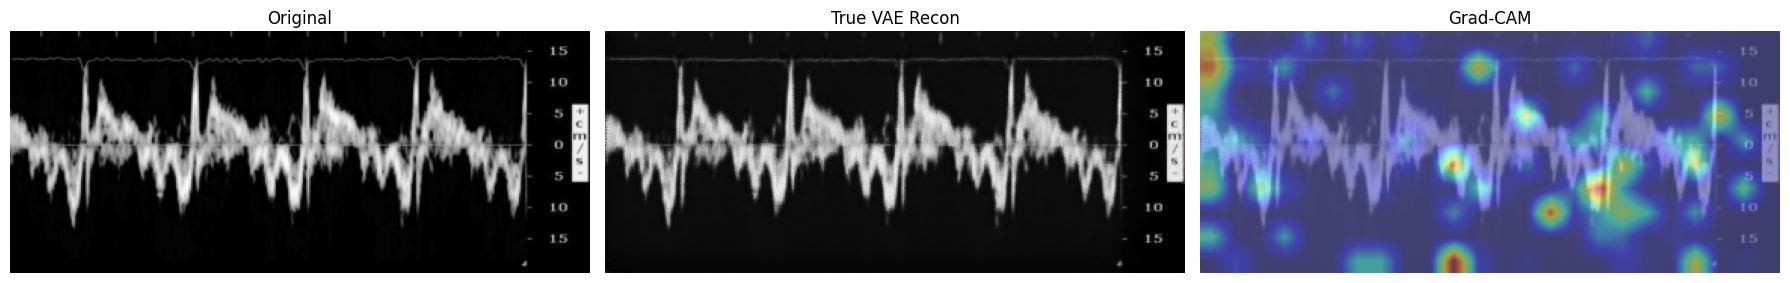

In [ ]:
# 1) Install dependencies
!pip install --quiet torch torchvision diffusers transformers

import os, glob
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms as T
from PIL import Image
from diffusers import UNet2DConditionModel, DDPMScheduler

# 2) Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 3) Paths & settings
DEVICE       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR     = '/content/drive/MyDrive/colab'
VAE_CKPT     = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi_perc.pt')
DIFF_CKPT    = os.path.join(BASE_DIR, 'saved_models', 'best_model.pt')
DATA_IMG_DIR = os.path.join(BASE_DIR, 'DATATDI')

IMAGE_SIZE   = (160, 384)
LATENT_SHAPE = (256, 10, 24)
CLINICAL_DIM = 26

# 4) Define ConvVAE
class ConvVAE(torch.nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act, self.out_act = torch.nn.ReLU(), torch.nn.Tanh()
        self.enc1 = torch.nn.Conv2d(1,32,4,2,1)
        self.enc2 = torch.nn.Conv2d(32,64,4,2,1)
        self.enc3 = torch.nn.Conv2d(64,128,4,2,1)
        self.enc4 = torch.nn.Conv2d(128,256,4,2,1)
        with torch.no_grad():
            dummy = torch.zeros(1,1,*img_size)
            h = self._encode_layers(dummy)
            self.conv_shape = h.shape[1:]
        flat_dim = int(torch.prod(torch.tensor(self.conv_shape)))
        self.fc_mu     = torch.nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = torch.nn.Linear(latent_dim, flat_dim)
        self.dec4 = torch.nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = torch.nn.ConvTranspose2d(128,64,4,2,1)
        self.dec2 = torch.nn.ConvTranspose2d(64,32,4,2,1)
        self.dec1 = torch.nn.ConvTranspose2d(32, 1,4,2,1)

    def _encode_layers(self, x):
        x = self.act(self.enc1(x))
        x = self.act(self.enc2(x))
        x = self.act(self.enc3(x))
        return self.act(self.enc4(x))

    def forward(self, x):
        h = self._encode_layers(x)
        flat = h.flatten(1)
        mu = self.fc_mu(flat)
        logvar = self.fc_logvar(flat)
        return mu, logvar, h

    def decode(self, h):
        d0 = self.fc_dec(h.flatten(1)).view(-1, *self.conv_shape)
        x = self.act(self.dec4(d0))
        x = self.act(self.dec3(x))
        x = self.act(self.dec2(x))
        return self.out_act(self.dec1(x))

vae = ConvVAE(latent_dim=LATENT_SHAPE[0], img_size=IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(VAE_CKPT, map_location=DEVICE))
vae.eval()

# 5) Load diffusion U-Net
model = UNet2DConditionModel(
    sample_size=LATENT_SHAPE[1:],
    in_channels=LATENT_SHAPE[0],
    out_channels=LATENT_SHAPE[0],
    down_block_types=("DownBlock2D",)*4,
    up_block_types=("UpBlock2D",)*4,
    block_out_channels=(128,256,512,1024),
    cross_attention_dim=CLINICAL_DIM,
).to(DEVICE)
model.load_state_dict(torch.load(DIFF_CKPT, map_location=DEVICE))
model.eval()

# 6) Scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=100)

# 7) Load a sample TDI image
sample = glob.glob(os.path.join(DATA_IMG_DIR, 'CTRCD','*.png'))[0]
tf = T.Compose([T.Grayscale(1), T.Resize(IMAGE_SIZE), T.ToTensor(), T.Normalize([0.5],[0.5])])
x = tf(Image.open(sample).convert('RGB')).unsqueeze(0).to(DEVICE)

# 8) True ConvVAE reconstruction
with torch.no_grad():
    # 1) Re-encode and save all encoder activations
    e1 = vae.act(vae.enc1(x))           # [1,32,H/2,W/2]
    e2 = vae.act(vae.enc2(e1))          # [1,64,H/4,W/4]
    e3 = vae.act(vae.enc3(e2))          # [1,128,H/8,W/8]
    e4 = vae.act(vae.enc4(e3))          # [1,256,H/16,W/16]  ← your conv_shape

    # 2) Bottleneck to mu/logvar → z
    flat = e4.flatten(1)
    mu, logvar = vae.fc_mu(flat), vae.fc_logvar(flat)
    z = mu  # use mean

    # 3) Decode with skips exactly as in forward()
    d0 = vae.fc_dec(z).view(-1, *vae.conv_shape)
    d1 = vae.act(vae.dec4(d0)) + e3
    d2 = vae.act(vae.dec3(d1)) + e2
    d3 = vae.act(vae.dec2(d2)) + e1
    recon = vae.out_act(vae.dec1(d3))  # [1,1,160,384]

# 9) Prepare noisy latent for diffusion
noise = torch.randn_like(h0)
ts = torch.randint(0, noise_scheduler.config.num_train_timesteps, (1,), device=DEVICE)
noisy = noise_scheduler.add_noise(h0, noise, ts)

# 10) Grad-CAM on last up-block conv
target = model.up_blocks[-1].resnets[-1].conv1
acts, grads = [], []

def f_hook(m, inp, out): acts.clear(); acts.append(out.detach())
def b_hook(m, gin, gout): grads.clear(); grads.append(gout[0].detach())

fh = target.register_forward_hook(f_hook)
bh = target.register_backward_hook(b_hook)

model.zero_grad()
out = model(noisy, ts, encoder_hidden_states=torch.zeros(1,1,CLINICAL_DIM, device=DEVICE)).sample
loss = out[0,0,0,0]
loss.backward()

fh.remove(); bh.remove()

# 11) Compute CAM
act = acts[0]    # [1,C,Hf,Wf]
grad = grads[0]
w = grad.mean(dim=(2,3), keepdim=True)
cam = F.relu((w * act).sum(dim=1, keepdim=True))[0,0]
cam = (cam - cam.min())/(cam.max()-cam.min())
cam_up = F.interpolate(cam.unsqueeze(0).unsqueeze(0),
                       size=(IMAGE_SIZE[0],IMAGE_SIZE[1]),
                       mode='bilinear', align_corners=False)[0,0].cpu()

# 12) Visualization

# Map both images to [0,1] for display
orig_np  = (x[0,0].cpu()*0.5 + 0.5).clamp(0,1).numpy()
recon_np = (recon[0,0].cpu()*0.5 + 0.5).clamp(0,1).numpy()

# Then plot “Original”, “True VAE Recon”, “Grad-CAM” as before
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(18,6))
ax0.imshow(orig_np,  cmap='gray'); ax0.set_title("Original");           ax0.axis('off')
ax1.imshow(recon_np, cmap='gray'); ax1.set_title("True VAE Recon");     ax1.axis('off')
ax2.imshow(recon_np, cmap='gray', alpha=0.6)
ax2.imshow(cam_up,   cmap='jet',  alpha=0.4); ax2.set_title("Grad-CAM"); ax2.axis('off')
plt.tight_layout()
plt.show()



<ipython-input-24-d862815cebed>:20: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02, hspace=0)


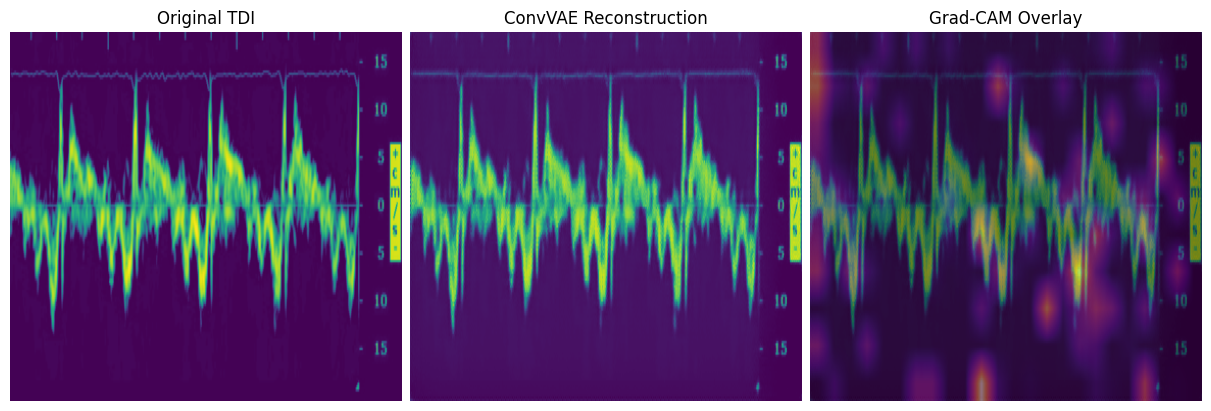

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

# Panel 1: Original TDI
axes[0].imshow(orig_np, cmap='viridis', aspect='auto')
axes[0].set_title("Original TDI", fontsize=12)
axes[0].axis('off')

# Panel 2: ConvVAE Reconstruction
axes[1].imshow(recon_np, cmap='viridis', aspect='auto')
axes[1].set_title("ConvVAE Reconstruction", fontsize=12)
axes[1].axis('off')

# Panel 3: Grad-CAM Overlay
axes[2].imshow(recon_np, cmap='viridis', aspect='auto')
axes[2].imshow(cam_up, cmap='inferno', alpha=0.4, aspect='auto')
axes[2].set_title("Grad-CAM Overlay", fontsize=12)
axes[2].axis('off')

# Remove all whitespace/margins
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.02, hspace=0)

# Save as high‐res, transparent background
plt.savefig("polished_tdi_xai.png", dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

In [ ]:
# ─── 0) (If needed) install deps ──────────────────────────────────────────────
# !pip install --quiet torch torchvision diffusers transformers

import os, glob, types
import torch
import torch.nn.functional as F
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel, DDPMScheduler
from google.colab import drive

# ─── 1) Mount Drive ───────────────────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

# ─── 2) Paths & settings ─────────────────────────────────────────────────────
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DIR      = '/content/drive/MyDrive/colab'
VAE_CKPT      = os.path.join(BASE_DIR, 'vae_analysis', 'vae_tdi_perc.pt')
DIFF_CKPT     = os.path.join(BASE_DIR, 'saved_models', 'best_model.pt')
DATA_IMG_DIR  = os.path.join(BASE_DIR, 'DATATDI')
IMAGE_SIZE    = (160, 384)
LATENT_SHAPE  = (256, 10, 24)   # (channels, H_lat, W_lat)
CLINICAL_DIM  = 26
Hf, Wf        = LATENT_SHAPE[1:]  # spatial dims for heatmap

# ─── 3) ConvVAE w/ skip-connections ───────────────────────────────────────────
class ConvVAE(torch.nn.Module):
    def __init__(self, latent_dim, img_size):
        super().__init__()
        self.act, self.out_act = torch.nn.ReLU(), torch.nn.Tanh()
        self.enc1 = torch.nn.Conv2d(1,  32, 4, 2, 1)
        self.enc2 = torch.nn.Conv2d(32, 64, 4, 2, 1)
        self.enc3 = torch.nn.Conv2d(64,128, 4, 2, 1)
        self.enc4 = torch.nn.Conv2d(128,256, 4, 2, 1)
        with torch.no_grad():
            _,_,_,e4 = self._encode(torch.zeros(1,1,*img_size))
            self.conv_shape = e4.shape[1:]
        flat_dim = int(torch.prod(torch.tensor(self.conv_shape)))
        self.fc_mu     = torch.nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = torch.nn.Linear(flat_dim, latent_dim)
        self.fc_dec    = torch.nn.Linear(latent_dim, flat_dim)
        self.dec4 = torch.nn.ConvTranspose2d(256,128,4,2,1)
        self.dec3 = torch.nn.ConvTranspose2d(128,64, 4,2,1)
        self.dec2 = torch.nn.ConvTranspose2d(64,32,  4,2,1)
        self.dec1 = torch.nn.ConvTranspose2d(32,1,   4,2,1)

    def _encode(self, x):
        e1 = self.act(self.enc1(x))
        e2 = self.act(self.enc2(e1))
        e3 = self.act(self.enc3(e2))
        e4 = self.act(self.enc4(e3))
        return e1, e2, e3, e4

    def forward(self, x):
        e1,e2,e3,e4 = self._encode(x)
        flat = e4.flatten(1)
        mu, logv = self.fc_mu(flat), self.fc_logvar(flat)
        self._skips = (e1,e2,e3)
        return mu, logv, e4

    def decode(self, z):
        d0 = self.fc_dec(z).view(-1, *self.conv_shape)
        e1,e2,e3 = self._skips
        d1 = self.act(self.dec4(d0)) + e3
        d2 = self.act(self.dec3(d1)) + e2
        d3 = self.act(self.dec2(d2)) + e1
        return self.out_act(self.dec1(d3))

# ─── 4) Load ConvVAE ─────────────────────────────────────────────────────────
vae = ConvVAE(latent_dim=LATENT_SHAPE[0], img_size=IMAGE_SIZE).to(DEVICE)
vae.load_state_dict(torch.load(VAE_CKPT, map_location=DEVICE))
vae.eval()

# ─── 5) Load diffusion U-Net ─────────────────────────────────────────────────
model = UNet2DConditionModel(
    sample_size=LATENT_SHAPE[1:],
    in_channels=LATENT_SHAPE[0],
    out_channels=LATENT_SHAPE[0],
    down_block_types=("DownBlock2D",)*4,
    up_block_types=("UpBlock2D",)*4,
    block_out_channels=(128,256,512,1024),
    cross_attention_dim=CLINICAL_DIM,
).to(DEVICE)
model.load_state_dict(torch.load(DIFF_CKPT, map_location=DEVICE))
model.eval()
noise_scheduler = DDPMScheduler(num_train_timesteps=100)

# ─── 6) Prepare a sample image ───────────────────────────────────────────────
img_file = glob.glob(os.path.join(DATA_IMG_DIR,'CTRCD','*.png'))[0]
tf = T.Compose([
    T.Grayscale(1),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.5],[0.5]),
])
x = tf(Image.open(img_file).convert("RGB")).unsqueeze(0).to(DEVICE)

# ─── 7) VAE encode + decode ──────────────────────────────────────────────────
with torch.no_grad():
    mu, logv, h0 = vae(x)
    recon       = vae.decode(mu)  # [1,1,H,W]

# ─── 8) Add noise ─────────────────────────────────────────────────────────────
noise = torch.randn_like(h0)
ts    = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                      (1,), device=DEVICE)
noisy = noise_scheduler.add_noise(h0, noise, ts)

# ─── 9) Locate cross-attention and patch forward ──────────────────────────────
mid = model.mid_block
ca  = mid.attentions[0].transformer_blocks[0].attn1
orig_forward = ca.forward

def forward_with_enc(self, hidden_states, encoder_hidden_states=None, **kwargs):
    self._enc = encoder_hidden_states
    # call with positional context arg, not named
    return orig_forward(hidden_states, encoder_hidden_states, **kwargs)

ca.forward = types.MethodType(forward_with_enc, ca)

# ─── 10) Hook to rebuild spatial attention map ───────────────────────────────
attn_map = None
def post_hook(module, inputs, output):
    global attn_map
    hidden = inputs[0]       # [B, N, C]
    enc    = module._enc     # [B, M, C]
    B, N, C = hidden.shape

    # project to queries & keys
    q = module.to_q(hidden)  # [B, N, heads*hd]
    k = module.to_k(enc)     # [B, M, heads*hd]

    heads    = module.heads
    total    = q.shape[-1]
    head_dim = total // heads

    # reshape → (B, heads, N, head_dim) & (B, heads, M, head_dim)
    q = q.view(B, N, heads, head_dim).permute(0,2,1,3)
    k = k.view(B, enc.shape[1], heads, head_dim).permute(0,2,1,3)

    # scaled dot-product & softmax
    scores = torch.matmul(q, k.transpose(-2,-1)) * (head_dim ** -0.5)
    probs  = torch.softmax(scores, dim=-1)

    # collapse heads, sum over keys → [B, N]
    m = probs.mean(dim=1).sum(dim=-1)

    # reshape to (Hf, Wf)
    attn_map = m.view(B, Hf, Wf).cpu()[0].numpy()

hook = ca.register_forward_hook(post_hook)

# ─── 11) Final forward to populate attn_map ─────────────────────────────────
conds = torch.zeros(1, 1, CLINICAL_DIM, device=DEVICE)
_ = model(noisy, ts, encoder_hidden_states=conds)
hook.remove()

# ─── 12) Upsample & overlay ───────────────────────────────────────────────────
orig_np  = (x[0,0].cpu()*0.5 + 0.5).clamp(0,1).numpy()
recon_np = (recon[0,0].cpu()*0.5 + 0.5).clamp(0,1).numpy()
attn_up  = F.interpolate(
    torch.from_numpy(attn_map).unsqueeze(0).unsqueeze(0),
    size=orig_np.shape,
    mode='bilinear',
    align_corners=False
)[0,0].numpy()

plt.figure(figsize=(6,6))
plt.imshow(recon_np, cmap='gray', alpha=0.8)
plt.imshow(attn_up,  cmap='hot',  alpha=0.4)
plt.title("Cross-Attention Heatmap on ConvVAE Recon")
plt.axis('off')
plt.show()


Mounted at /content/drive


TypeError: linear(): argument 'input' (position 1) must be Tensor, not NoneType